In [1]:

%pip install "numpy>=1.26" "pandas>=2.2" "scipy>=1.13" "scikit-learn>=1.5" "matplotlib>=3.8" "seaborn>=0.13" "tensorflow>=2.17,<3" "joblib>=1.3"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# ===== Imports & reproducibility (clean) =====
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import backend as K

# SciPy's implementation
from scipy.signal import find_peaks
from spectrum import Periodogram
from joblib import dump, load

from models import freqcoder, sincoder, RANCoders

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


In [2]:
# ==================== Load Data from CSV ====================
def load_data_from_csv(filepath: str):
    """Load data from a CSV file."""
    data = pd.read_csv(filepath)
    return data

In [3]:
# ==================== Perform EDA ====================
def perform_eda(data):
    """
    Perform exploratory data analysis on the dataset.
    
    Parameters:
    - data: pandas DataFrame containing the data
    """
    # Check for missing values
    print("Missing values:\n", data.isnull().sum())
    
    # Summary statistics
    print("Summary statistics:\n", data.describe())
    
    # Data distribution
    data.hist(bins=50, figsize=(20, 15))
    plt.show()

In [4]:
# ==================== Visualize Individual Signals ====================
def visualize_signals(data, signal_columns):
    """
    Visualize individual signals from the dataset.
    
    Parameters:
    - data: pandas DataFrame containing the data
    - signal_columns: list of columns to visualize
    """
    for column in signal_columns:
        plt.figure(figsize=(10, 4))
        plt.plot(data[column])
        plt.title(f'Signal: {column}')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.show()

In [5]:
# ==================== Handle Missing Data ====================
def handle_missing_data(data, method='interpolate'):
    """
    Handle missing data in the dataset.
    
    Parameters:
    - data: pandas DataFrame containing the data
    - method: str, method to handle missing data ('interpolate', 'fill', 'drop')
    
    Returns:
    - data: pandas DataFrame with handled missing data
    """
    if method == 'interpolate':
        data = data.interpolate()
    elif method == 'fill':
        data = data.fillna(method='ffill').fillna(method='bfill')
    elif method == 'drop':
        data = data.dropna()
    return data

In [6]:
# ==================== Evaluate Model ====================
def evaluate_model(y_true, y_pred, task='classification'):
    """
    Evaluate the model using appropriate metrics.
    
    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - task: str, 'classification' or 'regression'
    
    Returns:
    - metrics: dict, evaluation metrics
    """
    metrics = {}
    if task == 'classification':
        metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
        metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
        metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
        metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    elif task == 'regression':
        metrics['mse'] = mean_squared_error(y_true, y_pred)
        metrics['mae'] = mean_absolute_error(y_true, y_pred)
    
    return metrics

In [7]:
# ==================== Anomaly Metrics ====================
def anomaly_metrics(x, o_hi, o_lo):
    """
    Compute simple anomaly metrics based on bound violations.
    Returns coverage (fraction inside bounds) and mean positive violation.
    """
    pos_excess = np.maximum(0, x - o_hi) + np.maximum(0, o_lo - x)
    coverage = float((pos_excess == 0).mean())
    mean_violation = float(pos_excess[pos_excess > 0].mean()) if np.any(pos_excess > 0) else 0.0
    return {"coverage": coverage, "mean_violation": mean_violation}

In [8]:
# ==================== Test Model on Unseen Data ====================
def test_model_on_unseen_data(model, x_test, t_test):
    """
    Test the model on unseen data.
    
    Parameters:
    - model: trained model
    - x_test: array-like, test features
    - t_test: array-like, test time steps
    
    Returns:
    - predictions: array-like, model predictions
    """
    predictions = model.predict(x_test, t_test)
    if isinstance(predictions, tuple) and len(predictions) == 2:
        predictions = (predictions[0] + predictions[1]) / 2.0
    return predictions

In [9]:
# ==================== Validate Root Cause Identification ====================
def validate_root_cause(predictions, true_causes):
    """
    Validate the root cause identification mechanism.
    
    Parameters:
    - predictions: array-like, model predictions
    - true_causes: array-like, true root causes
    
    Returns:
    - accuracy: float, accuracy of root cause identification
    """
    accuracy = np.mean(predictions == true_causes)
    return accuracy

In [10]:
def _assign_sinc_weights(sinc_layer, a_adj, wb_adj, g_adj):
    """
    Robustly assign amp/wb/disp into the sincoder *layer* (not the whole Model).
    Uses .assign() on full tensors to avoid slice-assignment issues.
    """
    import numpy as np
    import tensorflow as tf

    a_adj = np.asarray(a_adj, dtype=np.float32)
    wb_adj = np.asarray(wb_adj, dtype=np.float32)
    g_adj = np.asarray(g_adj, dtype=np.float32)

    # amp: (F, max_freqs) -> set first column
    amp_full = sinc_layer.amp.numpy()
    if a_adj.shape[0] != amp_full.shape[0]:
        raise ValueError(f"amp shape mismatch: amp={amp_full.shape} vs a_adj={a_adj.shape}")
    amp_full[:, 0] = a_adj
    sinc_layer.amp.assign(amp_full)

    # wb: (F, max_freqs) -> set first column
    wb_full = sinc_layer.wb.numpy()
    if wb_adj.shape[0] != wb_full.shape[0]:
        raise ValueError(f"wb shape mismatch: wb={wb_full.shape} vs wb_adj={wb_adj.shape}")
    wb_full[:, 0] = wb_adj
    sinc_layer.wb.assign(wb_full)

    # disp: (F,)
    if g_adj.shape[0] != sinc_layer.disp.shape[0]:
        raise ValueError(f"disp shape mismatch: disp={sinc_layer.disp.shape} vs g_adj={g_adj.shape}")
    sinc_layer.disp.assign(g_adj)


In [11]:
def _get_sinc_layer_from_model(sinc_model):
    """
    Return the sincoder *layer*. Works whether you passed the layer itself
    or a Keras Model that contains it.
    """
    if sinc_model is None:
        raise RuntimeError("sincoder not built; call build(...) first")

    # Case 1: sinc_model IS the layer (our current setup)
    if all(hasattr(sinc_model, a) for a in ("amp", "wb", "disp", "freq")):
        return sinc_model

    # Case 2: sinc_model is a Model that contains the layer
    for lyr in getattr(sinc_model, "layers", []):
        if all(hasattr(lyr, a) for a in ("amp", "wb", "disp", "freq")):
            return lyr

    # Optional fallback (older notebooks sometimes put it at index 1)
    layers_attr = getattr(sinc_model, "layers", [])
    if len(layers_attr) >= 2:
        cand = layers_attr[1]
        if all(hasattr(cand, a) for a in ("amp", "wb", "disp", "freq")):
            return cand

    raise RuntimeError(
        "Could not locate sincoder layer (amp/wb/disp/freq). "
        "Make sure build(...) created self.sincoder as the layer or a Model containing it."
    )

In [ ]:
from typing import Optional, List

# ==================== RANSynCoders Class ====================
class RANSynCoders():
    """ class for building, training, and testing rancoders models """
    def __init__(
            self,
            # Rancoders inputs:
            n_estimators: int = 100,
            max_features: int = 3,
            encoding_depth: int = 2,
            latent_dim: int = 2, 
            decoding_depth: int = 2,
            activation: str = 'linear',
            output_activation: str = 'linear',
            delta: float = 0.05,  # quantile bound for regression
            # Syncrhonization inputs
            synchronize: bool = False,
            force_synchronization: bool = True,  # if synchronization is true but no significant frequencies found
            min_periods: int = 3,  # if synchronize and forced, this is the minimum bound on cycles to look for in train set
            freq_init: Optional[List[float]] = None,  # initial guess for the dominant angular frequency
            max_freqs: int = 1,  # the number of sinusoidal signals to fit
            min_dist: int = 60,  # maximum distance for finding local maximums in the PSD
            trainable_freq: bool = False,  # whether to make the frequency a variable during layer weight training
            bias: bool = True,  # add intercept (vertical displacement)
    ):
        # Rancoders inputs:
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.encoding_depth = encoding_depth
        self.latent_dim = latent_dim
        self.decoding_depth = decoding_depth
        self.activation = activation
        self.output_activation = output_activation
        self.delta = delta
        
        # Syncrhonization inputs
        self.synchronize = synchronize
        self.force_synchronization = force_synchronization
        self.min_periods = min_periods
        self.freq_init = freq_init  # in radians (angular frequency)
        self.max_freqs = max_freqs
        self.min_dist = min_dist
        self.trainable_freq = trainable_freq
        self.bias = bias
        
        # set all variables to default to float32
        tf.keras.backend.set_floatx('float32')

    def build(self, n_features: int):
        # ---- set optimizers (since we won't use Model.compile) ----
        self._ranc_opt = tf.keras.optimizers.Adam()
        self._sin_opt  = tf.keras.optimizers.Adam()

        # ---- instantiate models directly (subclass/eager style) ----
        self.rancoders = RANCoders(
            n_estimators=self.n_estimators,
            max_features=self.max_features,
            encoding_depth=self.encoding_depth,
            latent_dim=self.latent_dim,
            decoding_depth=self.decoding_depth,
            delta=self.delta,
            activation=self.activation,
            output_activation=self.output_activation,
            name='rancoders'
        )
        # build weights by calling once on a dummy batch
        _ = self.rancoders(tf.zeros((1, n_features), dtype=tf.float32), training=False)

        if self.synchronize:
            self.sincoder = sincoder(freq_init=self.freq_init, trainable_freq=self.trainable_freq)
            _ = self.sincoder(tf.zeros((1, n_features), dtype=tf.float32), training=False)


        
    def fit(
            self, 
            x: np.ndarray, 
            t: np.ndarray,
            epochs: int = 25, 
            batch_size: int = 360, 
            shuffle: bool = True, 
            freq_warmup: int = 10,  # number of warmup epochs to prefit the frequency
            sin_warmup: int = 10,  # number of warmup epochs to prefit the sinusoidal representation
            pos_amp: bool = True,  # whether to constraint amplitudes to be +ve only
    ):
        
        # Prepare the training batches.
        dataset = tf.data.Dataset.from_tensor_slices(
            (x.astype(np.float32), t.astype(np.float32))
        )
        if shuffle:
            dataset = dataset.shuffle(buffer_size=x.shape[0], reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size)  # <-- ALWAYS batch, even if not shuffled



        # --- build models once (no freqcoder; spectral init instead) ---
        if not hasattr(self, "rancoders") or (self.synchronize and not hasattr(self, "sincoder")):
            # If no initial freq_init given, compute from the current x via spectrum
            if self.synchronize and not self.freq_init:
                ang_list = _spectral_freq_init_from_batch(
                    x, self.min_periods, self.max_freqs, self.min_dist, self.force_synchronization
                )
                if ang_list is None:
                    # no oscillation signal at all -> turn off sync
                    self.synchronize = False
                    print("[sync] No common oscillation found; turning synchronization OFF.")
                elif len(ang_list) == 0:
                    # no strong peaks but user requested force
                    if self.force_synchronization:
                        # safe fallback ~1000-sample period
                        self.freq_init = [2.0 * np.pi / 1000.0]
                        print("[sync] No strong peaks; forcing sync with fallback period ~1000 samples.")
                    else:
                        self.synchronize = False
                        print("[sync] No common oscillation; synchronization OFF.")
                else:
                    self.freq_init = ang_list
                    periods = [(2.0 * np.pi) / w for w in ang_list]
                    print(f"[sync] Spectral init periods: {periods}")

            # build rancoders (+ sincoder if synchronize=True)
            self.build(x.shape[1])  # <-- RIGHT

        
        # pretraining step :
        if sin_warmup > 0 and self.synchronize and not getattr(self, "_sine_warmup_done", False):
            for epoch in range(sin_warmup):
                print("\nStart of sine representation pre-train epoch %d" % (epoch,))
                for step, (x_batch, t_batch) in enumerate(dataset):
                    # Train the sine wave encoder
                    with tf.GradientTape() as tape:
                        s = self.sincoder(t_batch, training=True)
                        s_loss = quantile_loss(0.5, x_batch, s)

                    grads = tape.gradient(s_loss, self.sincoder.trainable_weights)
                    self._sin_opt.apply_gradients(zip(grads, self.sincoder.trainable_weights))

                print("sine_loss:", tf.reduce_mean(s_loss).numpy(), end='\r')
            
            # invert params (all amplitudes should either be -ve or +ve). Here we make them +ve
            if pos_amp:
                sinc_layer = _get_sinc_layer_from_model(self.sincoder)

                # Work in eager/NumPy to avoid slice-assign on Variables
                amp_now  = sinc_layer.amp.numpy()      # (F, max_freqs)
                wb_now   = sinc_layer.wb.numpy()       # (F, max_freqs)
                disp_now = sinc_layer.disp.numpy()     # (F,)

                neg_mask = amp_now[:, 0] < 0.0

                a_adj = np.where(neg_mask, -amp_now[:, 0], amp_now[:, 0])
                wb_adj = np.where(neg_mask, wb_now[:, 0] + np.pi, wb_now[:, 0])

                # Robust phase wrap to [0, 2π)
                two_pi = 2.0 * np.pi
                wb_adj = np.mod(wb_adj, two_pi)

                g_adj = np.where(neg_mask, disp_now - a_adj, disp_now)

                _assign_sinc_weights(sinc_layer, a_adj, wb_adj, g_adj)

                self._sine_warmup_done = True
            

        # train anomaly detector
        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            if self.synchronize:
                for step, (x_batch, t_batch) in enumerate(dataset):
                    # Train the sine wave encoder
                    with tf.GradientTape() as tape:
                        s = self.sincoder(t_batch, training=True)
                        s_loss = quantile_loss(0.5, x_batch, s)
                    grads = tape.gradient(s_loss, self.sincoder.trainable_weights)
                    self._sin_opt.apply_gradients(zip(grads, self.sincoder.trainable_weights))
                    
                    # synchronize batch (robust layer access + stable trig)
                    sinc_layer = _get_sinc_layer_from_model(self.sincoder)
                    freq = sinc_layer.freq     # (max_freqs,)
                    wb   = sinc_layer.wb       # (F, max_freqs)
                    amp  = sinc_layer.amp      # (F, max_freqs)
                    disp = sinc_layer.disp     # (F,)

                    freq_safe = tf.maximum(freq, 1e-6)
                    b = wb / freq_safe
                    b_sync = b - tf.expand_dims(b[:, 0], axis=-1)

                    th_sync = tf.expand_dims(tf.expand_dims(freq, axis=0), axis=0) * (
                        tf.expand_dims(t_batch, axis=-1) + tf.expand_dims(b_sync, axis=0)
                    )

                    # sin(f*(π/(2f) - b)) == cos(f*b)
                    e = (x_batch - s) * tf.cos(freq[0] * b[:, 0])

                    x_batch_sync = tf.reduce_sum(
                        tf.expand_dims(amp, axis=0) * tf.sin(th_sync), axis=-1
                    ) + disp + e


                    
                    # train the rancoders
                    with tf.GradientTape() as tape:
                        o_hi, o_lo = self.rancoders(x_batch_sync, training=True)
                        target = tf.tile(tf.expand_dims(x_batch_sync, axis=0), (self.n_estimators, 1, 1))
                        o_hi_loss = quantile_loss(1.0 - self.delta, target, o_hi)
                        o_lo_loss = quantile_loss(self.delta,          target, o_lo)
                        o_loss = o_hi_loss + o_lo_loss
                    grads = tape.gradient(o_loss, self.rancoders.trainable_weights)
                    self._ranc_opt.apply_gradients(zip(grads, self.rancoders.trainable_weights))
                print(
                    "sine_loss:", tf.reduce_mean(s_loss).numpy(), 
                    "upper_bound_loss:", tf.reduce_mean(o_hi_loss).numpy(), 
                    "lower_bound_loss:", tf.reduce_mean(o_lo_loss).numpy(), 
                    end='\r'
                )
            else:
                for step, (x_batch, t_batch) in enumerate(dataset):
                    with tf.GradientTape() as tape:
                        o_hi, o_lo = self.rancoders(x_batch, training=True)
                        target = tf.tile(tf.expand_dims(x_batch, axis=0), (self.n_estimators, 1, 1))
                        o_hi_loss = quantile_loss(1.0 - self.delta, target, o_hi)
                        o_lo_loss = quantile_loss(self.delta,          target, o_lo)
                        o_loss = o_hi_loss + o_lo_loss

                    grads = tape.gradient(o_loss, self.rancoders.trainable_weights)
                    self._ranc_opt.apply_gradients(zip(grads, self.rancoders.trainable_weights))

                print(
                    "upper_bound_loss:", tf.reduce_mean(o_hi_loss).numpy(), 
                    "lower_bound_loss:", tf.reduce_mean(o_lo_loss).numpy(), 
                    end='\r'
                )
            
    def predict(self, x: np.ndarray, t: np.ndarray, batch_size: int = 1000, desync: bool = False):
        # Prepare the training batches.
        dataset = tf.data.Dataset.from_tensor_slices((x.astype(np.float32), t.astype(np.float32)))
        dataset = dataset.batch(batch_size)
        batches = int(np.ceil(x.shape[0] / batch_size))
        
        # loop through the batches of the dataset.
        if self.synchronize:
            s, x_sync, o_hi, o_lo = [None] * batches, [None] * batches, [None] * batches, [None] * batches
            for step, (x_batch, t_batch) in enumerate(dataset):
                # forward pass of the sincoder
                s_i = self.sincoder(t_batch).numpy()

                # robustly get the actual sinc layer (works across notebook reloads)
                sinc_layer = _get_sinc_layer_from_model(self.sincoder)
                freq = sinc_layer.freq   # shape: (max_freqs,)
                wb   = sinc_layer.wb     # shape: (F, max_freqs)
                amp  = sinc_layer.amp    # shape: (F, max_freqs)
                disp = sinc_layer.disp   # shape: (F,)

                # Safe divide & stable trig
                freq_safe = tf.maximum(freq, 1e-6)       # avoid div-by-zero
                b = wb / freq_safe                       # phase shift(s), shape (F, max_freqs)
                b_sync = b - tf.expand_dims(b[:, 0], axis=-1)

                # synchronized angle for aligned signal
                th_sync = tf.expand_dims(tf.expand_dims(freq, axis=0), axis=0) * (
                    tf.expand_dims(t_batch, axis=-1) + tf.expand_dims(b_sync, axis=0)
                )

                # sin(f*(π/(2f) - b)) == cos(f*b)  -> avoids inf/NaN when f≈0
                e = (x_batch - s_i) * tf.cos(freq[0] * b[:, 0])

                # final synchronized batch
                x_sync_i = (tf.reduce_sum(tf.expand_dims(amp, axis=0) * tf.sin(th_sync), axis=-1)
                            + disp + e).numpy()
  
                o_hi_i, o_lo_i = self.rancoders(x_sync_i)
                o_hi_i, o_lo_i = tf.transpose(o_hi_i, [1,0,2]).numpy(), tf.transpose(o_lo_i, [1,0,2]).numpy()
                if desync:
                    o_hi_i, o_lo_i = self.predict_desynchronize(x_batch, x_sync_i, o_hi_i, o_lo_i)
                s[step], x_sync[step], o_hi[step], o_lo[step]  = s_i, x_sync_i, o_hi_i, o_lo_i
            return (
                np.concatenate(s, axis=0), 
                np.concatenate(x_sync, axis=0), 
                np.concatenate(o_hi, axis=0), 
                np.concatenate(o_lo, axis=0)
            )
        else:
            o_hi, o_lo = [None] * batches, [None] * batches
            for step, (x_batch, t_batch) in enumerate(dataset):
                o_hi_i, o_lo_i = self.rancoders(x_batch)
                o_hi_i, o_lo_i = tf.transpose(o_hi_i, [1,0,2]).numpy(), tf.transpose(o_lo_i, [1,0,2]).numpy()
                o_hi[step], o_lo[step]  = o_hi_i, o_lo_i
            return np.concatenate(o_hi, axis=0), np.concatenate(o_lo, axis=0)
        
    def save(self, filepath: Optional[str] = None):
        if filepath is None:
            filepath = os.path.join(os.getcwd(), "ransyncoders.z")
        file = {'params': self.get_config()}
        if hasattr(self, "freqcoder"):  # guard
            file['freqcoder'] = {'model': self.freqcoder.to_json(), 'weights': self.freqcoder.get_weights()}
        if self.synchronize:
            file['sincoder'] = {'model': self.sincoder.to_json(), 'weights': self.sincoder.get_weights()}
        file['rancoders'] = {'model': self.rancoders.to_json(), 'weights': self.rancoders.get_weights()}
        dump(file, filepath, compress=True)

    @classmethod
    def load(cls, filepath: Optional[str] = None):
        if filepath is None:
            filepath = os.path.join(os.getcwd(), "ransyncoders.z")
        file = load(filepath)
        inst = cls()
        for param, val in file['params'].items():
            setattr(inst, param, val)
        if 'freqcoder' in file:
            inst.freqcoder = model_from_json(file['freqcoder']['model'], custom_objects={'freqcoder': freqcoder})
            inst.freqcoder.set_weights(file['freqcoder']['weights'])
        if inst.synchronize and 'sincoder' in file:
            inst.sincoder = model_from_json(file['sincoder']['model'], custom_objects={'sincoder': sincoder})
            inst.sincoder.set_weights(file['sincoder']['weights'])
        inst.rancoders = model_from_json(file['rancoders']['model'], custom_objects={'RANCoders': RANCoders})
        inst.rancoders.set_weights(file['rancoders']['weights'])
        return inst


    
    def predict_desynchronize(self, x: np.ndarray, x_sync: np.ndarray, o_hi: np.ndarray, o_lo: np.ndarray):
        if self.synchronize:
            E = (o_hi + o_lo)/ 2  # expected values
            deviation = tf.expand_dims(x_sync, axis=1) - E  # input (synchronzied) deviation from expected
            deviation = self.desynchronize(deviation)  # desynchronize
            E = tf.expand_dims(x, axis=1) - deviation  # expected values in desynchronized form
            offset = (o_hi - o_lo) / 2  # this is the offet from the expected value
            offset = abs(self.desynchronize(offset))  # desynch
            o_hi, o_lo = E + offset, E - offset  # add bound displacement to expected values
            return o_hi.numpy(), o_lo.numpy()  
        else:
            raise ParameterError('synchronize', 'parameter not set correctly for this method')
    
    def desynchronize(self, e: np.ndarray):
        if not self.synchronize:
            raise ParameterError('synchronize', 'parameter not set correctly for this method')

        sinc_layer = _get_sinc_layer_from_model(self.sincoder)
        freq = sinc_layer.freq
        wb   = sinc_layer.wb

        freq_safe = tf.maximum(freq, 1e-6)
        b = wb / freq_safe  # (F, max_freqs)

        # sin(f*(π/(2f)+b)) == cos(f*b)
        return (e * tf.cos(freq[0] * b[:, 0])).numpy()


        
        
    def get_config(self):
        config = {
            "n_estimators": self.n_estimators,
            "max_features": self.max_features,
            "encoding_depth": self.encoding_depth,
            "latent_dim": self.latent_dim,
            "decoding_depth": self.decoding_depth,
            "activation": self.activation,
            "output_activation": self.output_activation,
            "delta": self.delta,
            "synchronize": self.synchronize,
            "force_synchronization": self.force_synchronization,
            "min_periods": self.min_periods,
            "freq_init": self.freq_init,
            "max_freqs": self.max_freqs,
            "min_dist": self.min_dist,
            "trainable_freq": self.trainable_freq,
            "bias": self.bias,
        }
        return config
        
        
# Loss function
def quantile_loss(q, y, f):
    e = (y - f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)


class ParameterError(Exception):

    def __init__(self, expression, message):
        self.expression = expression
        self.message = message

Resolved columns: ['aimp', 'amud', 'adbr', 'adfl', 'arnd', 'asin1', 'asin2', 'bed1', 'bed2', 'bfo1', 'bfo2', 'bso1', 'bso2', 'bso3', 'ced1', 'cso1', 'cfo1']
[EDA] Nominal (first 100k): shape=(100000, 17)
Missing values:
 aimp     0
amud     0
arnd     0
asin1    0
asin2    0
adbr     0
adfl     0
bed1     0
bed2     0
bfo1     0
bfo2     0
bso1     0
bso2     0
bso3     0
ced1     0
cfo1     0
cso1     0
dtype: int64
Summary statistics:
                aimp           amud           arnd          asin1  \
count  100000.00000  100000.000000  100000.000000  100000.000000   
mean        0.01010       2.216250      21.152513       0.708069   
std         0.09999       4.585551      11.061474       0.305345   
min         0.00000     -13.000000      10.000000       0.000000   
25%         0.00000       0.000000      12.420216       0.479421   
50%         0.00000       2.000000      17.101356       0.841466   
75%         0.00000       5.000000      26.357841       0.968912   
max         1.

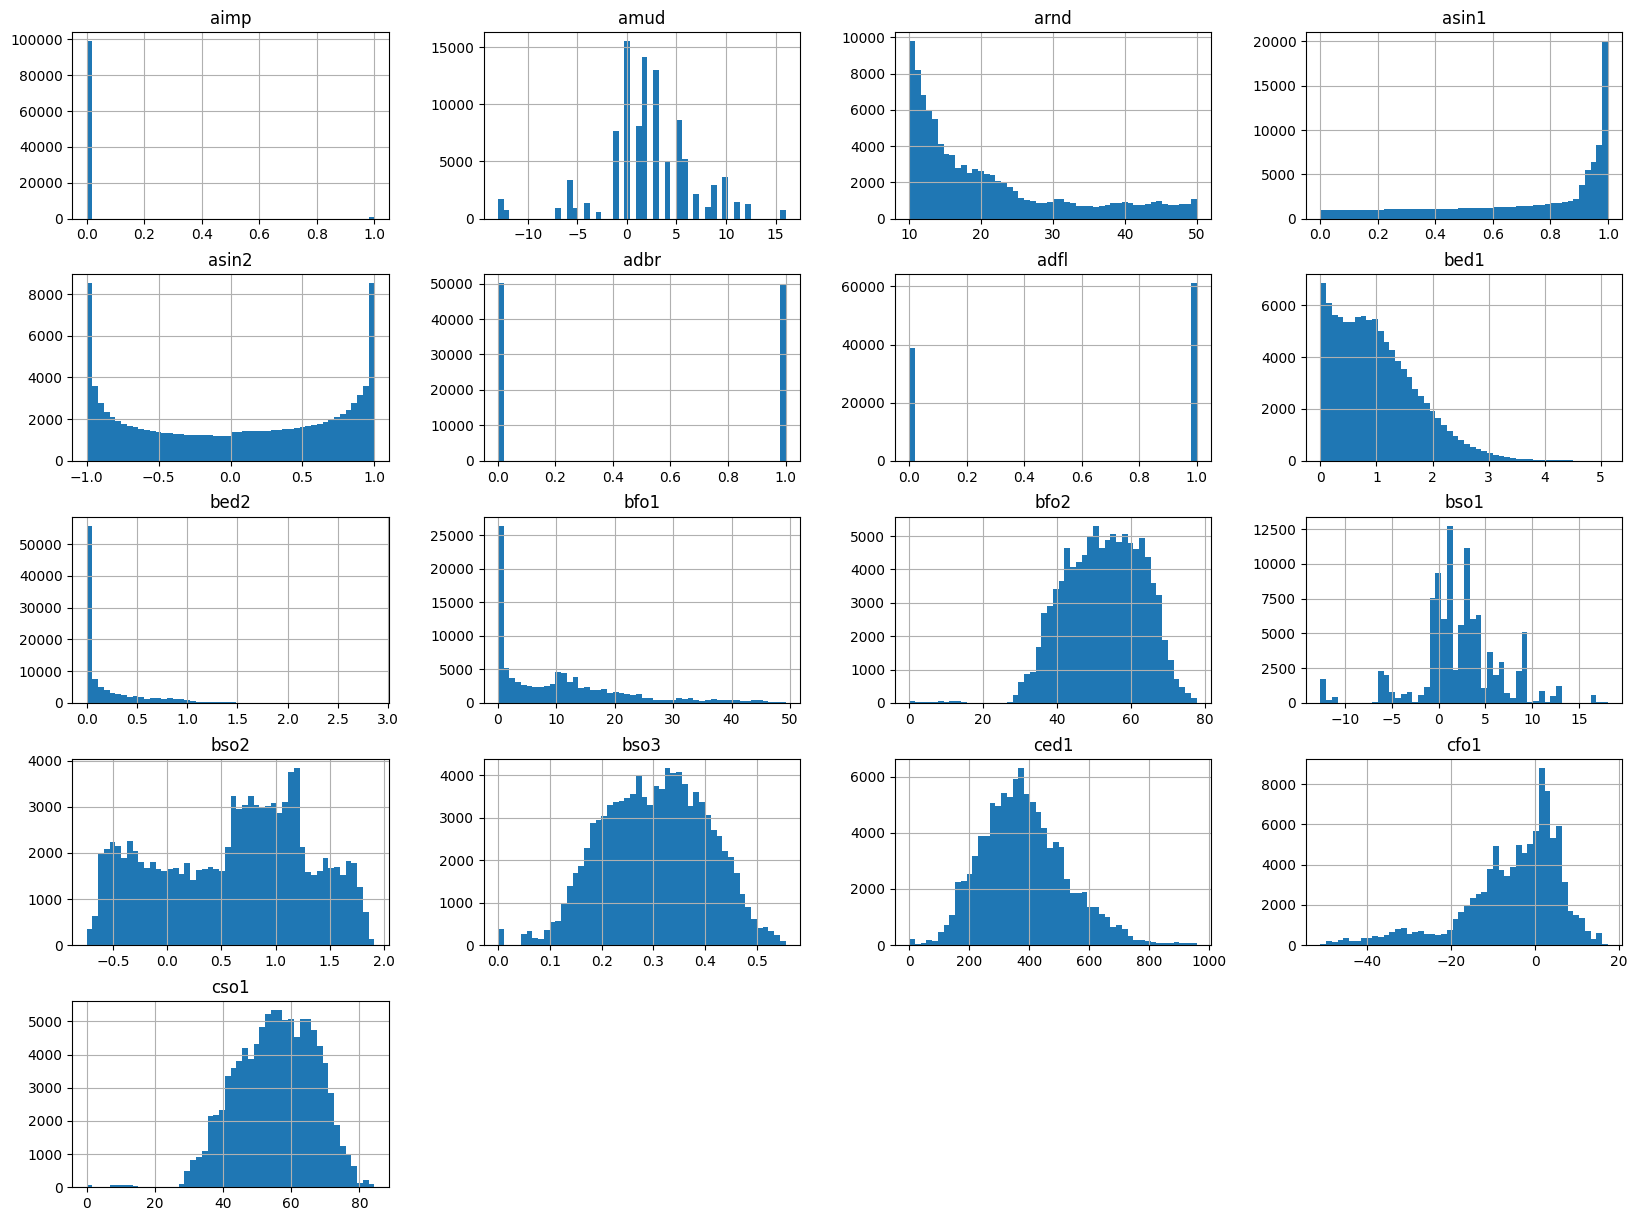

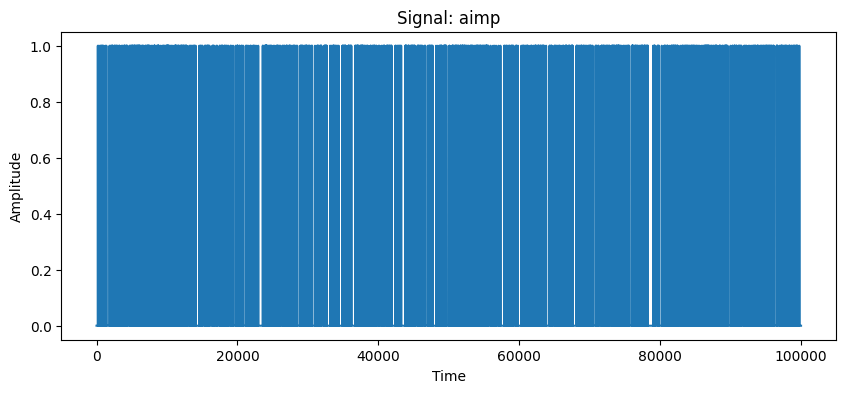

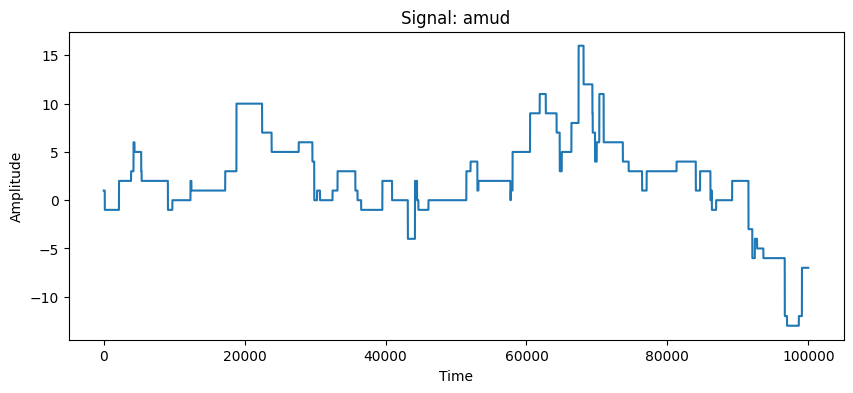

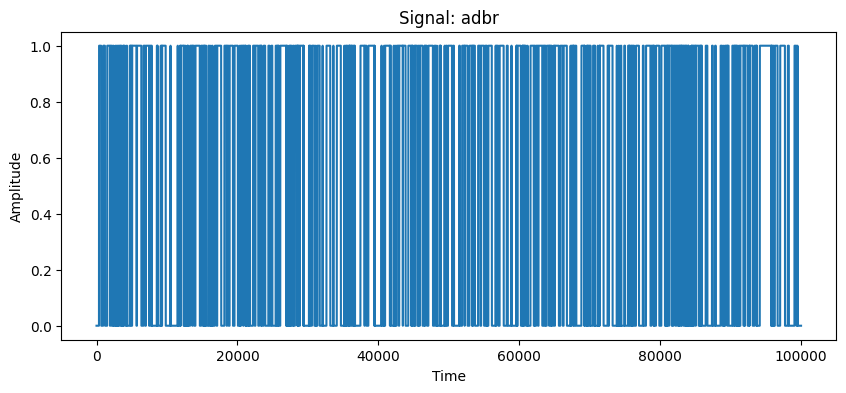

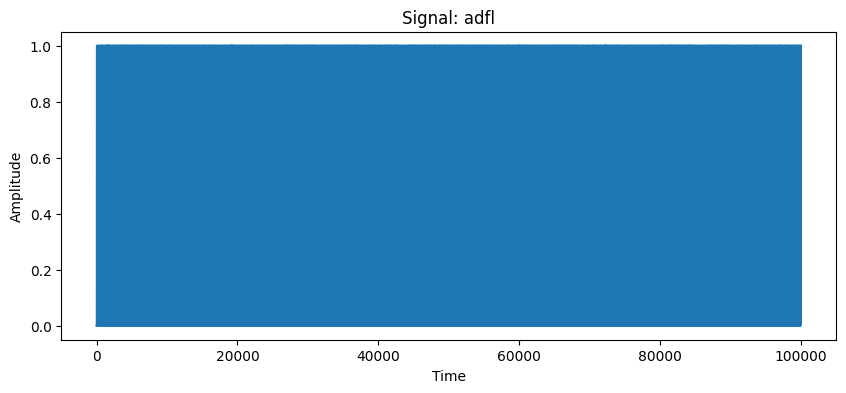

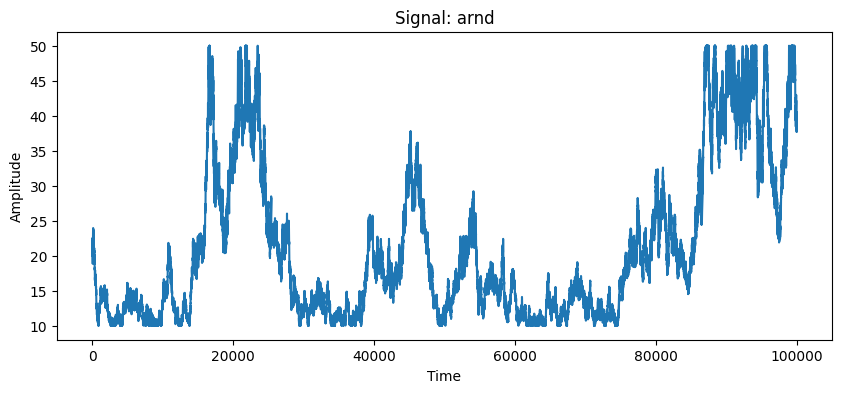

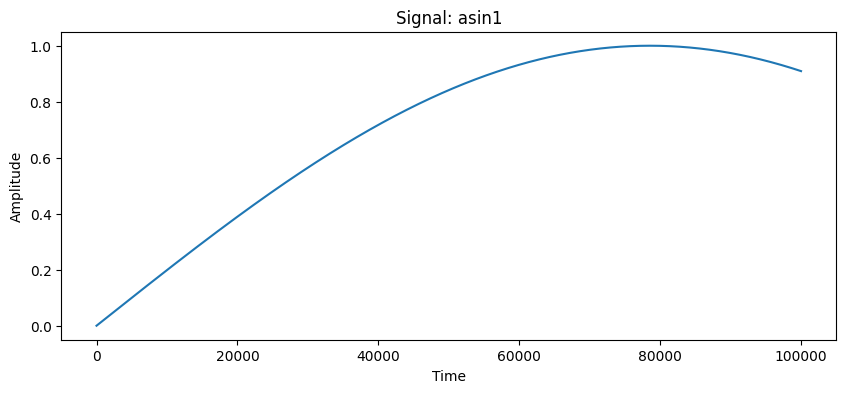

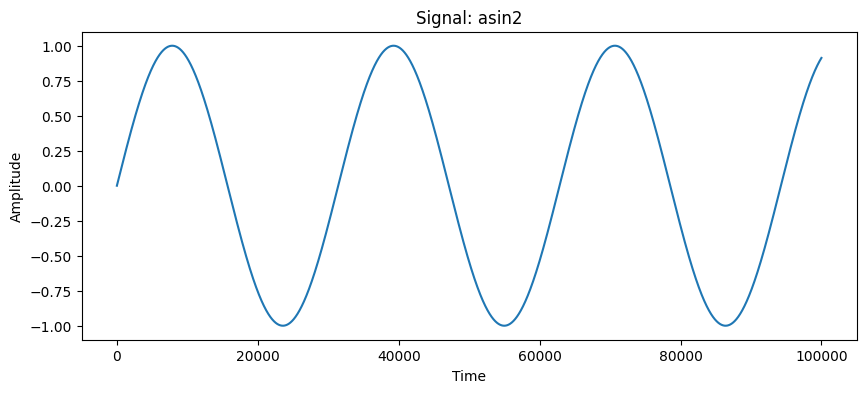

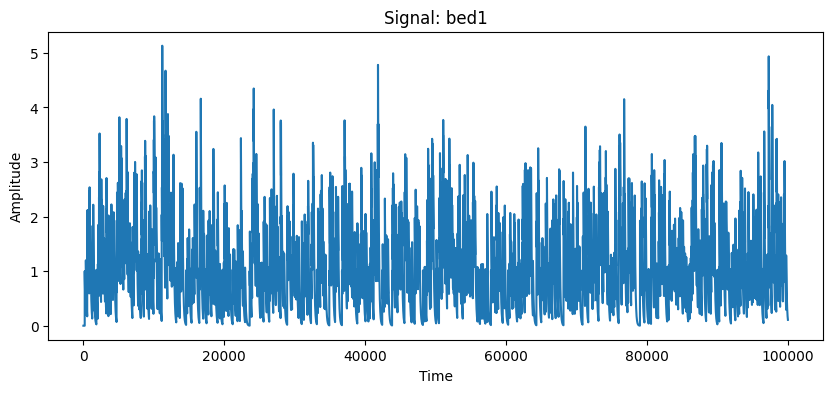

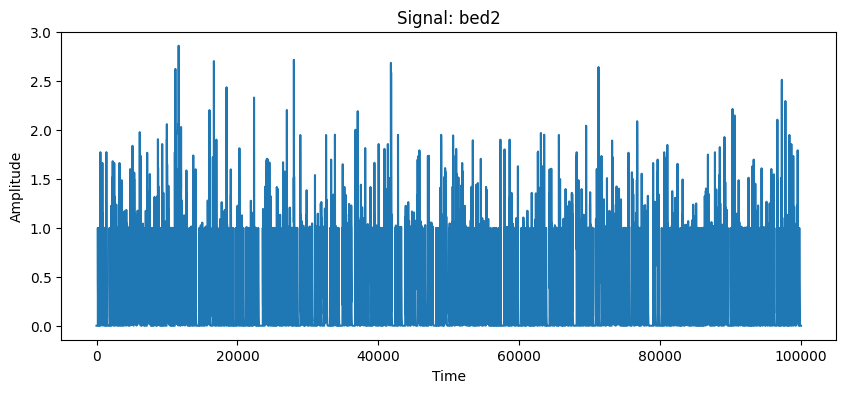

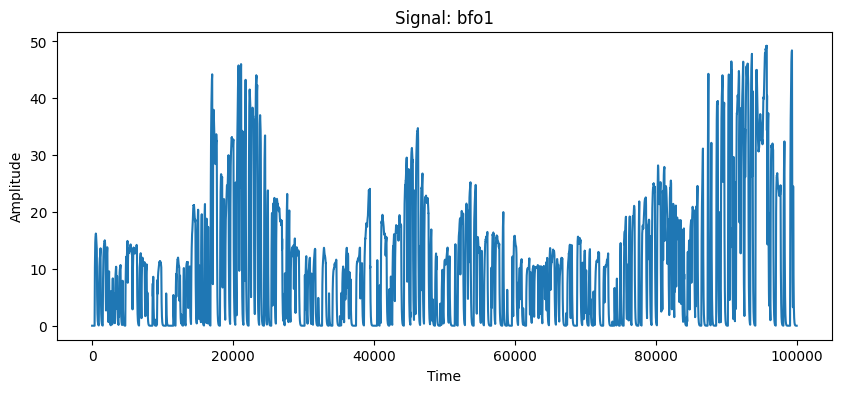

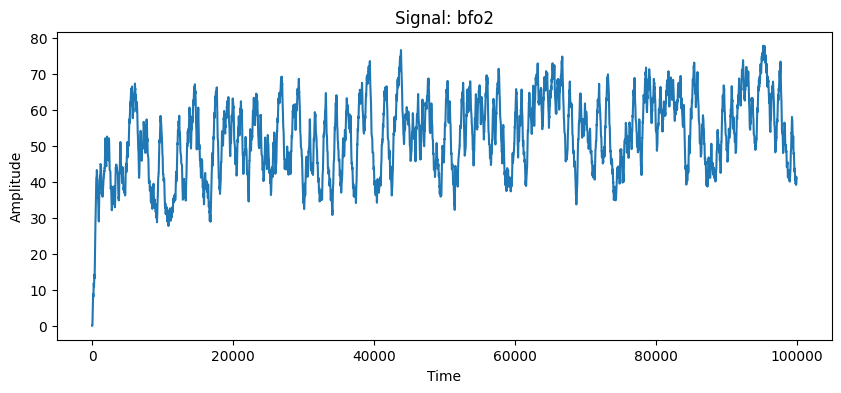

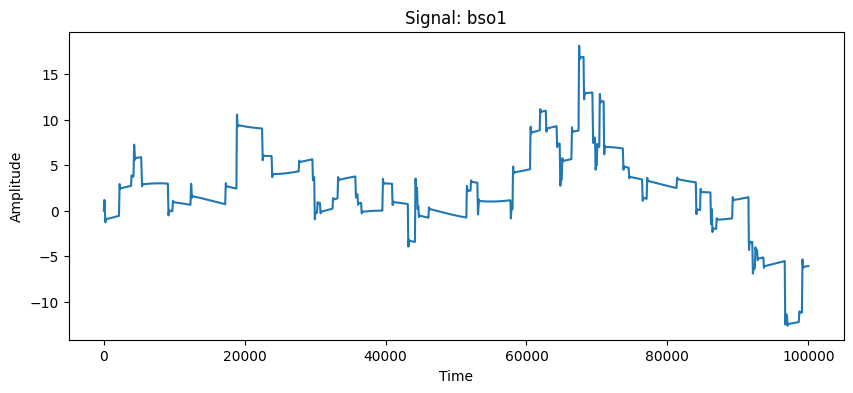

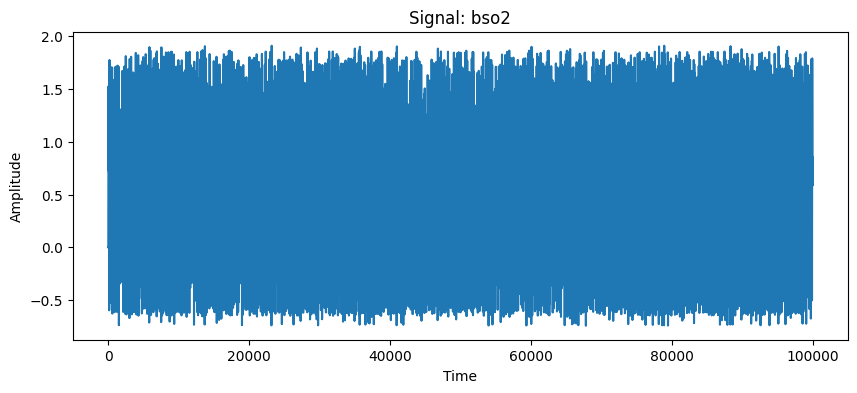

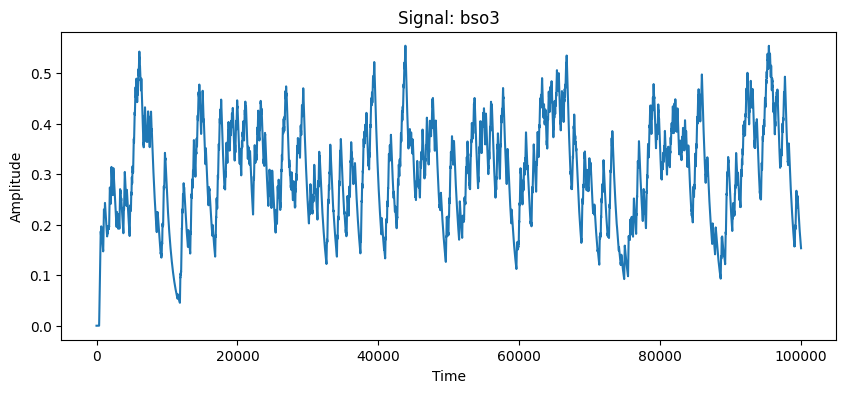

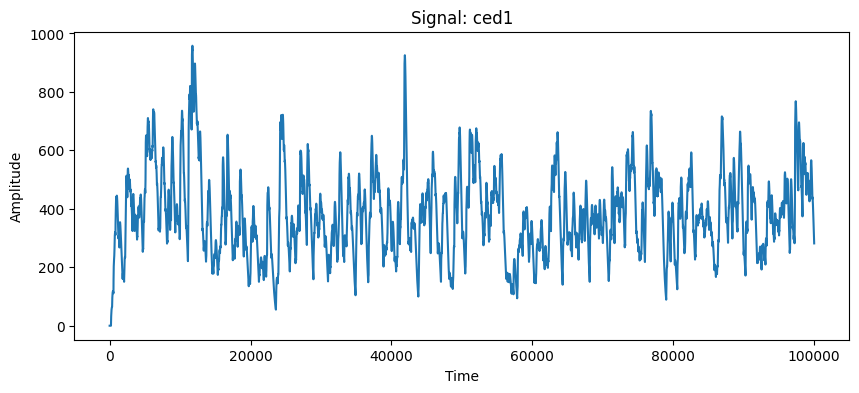

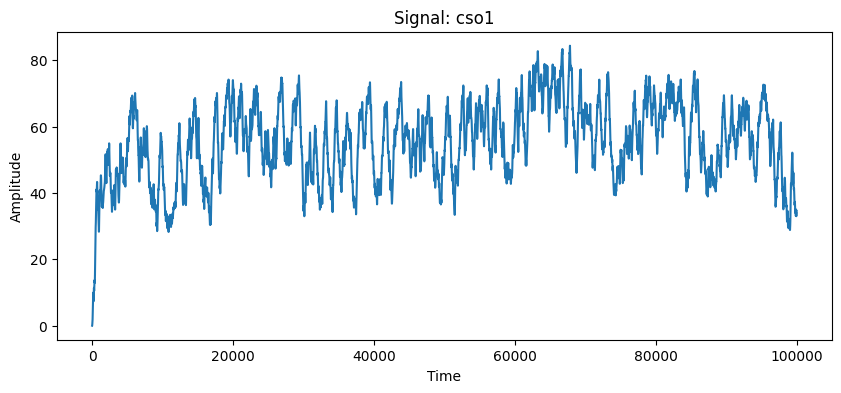

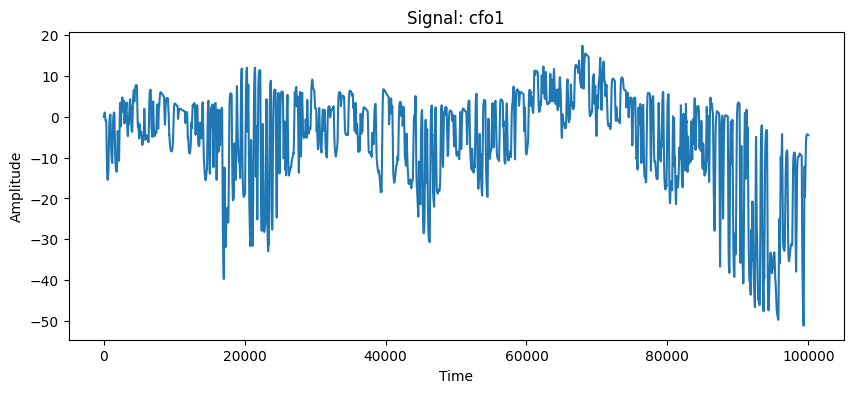

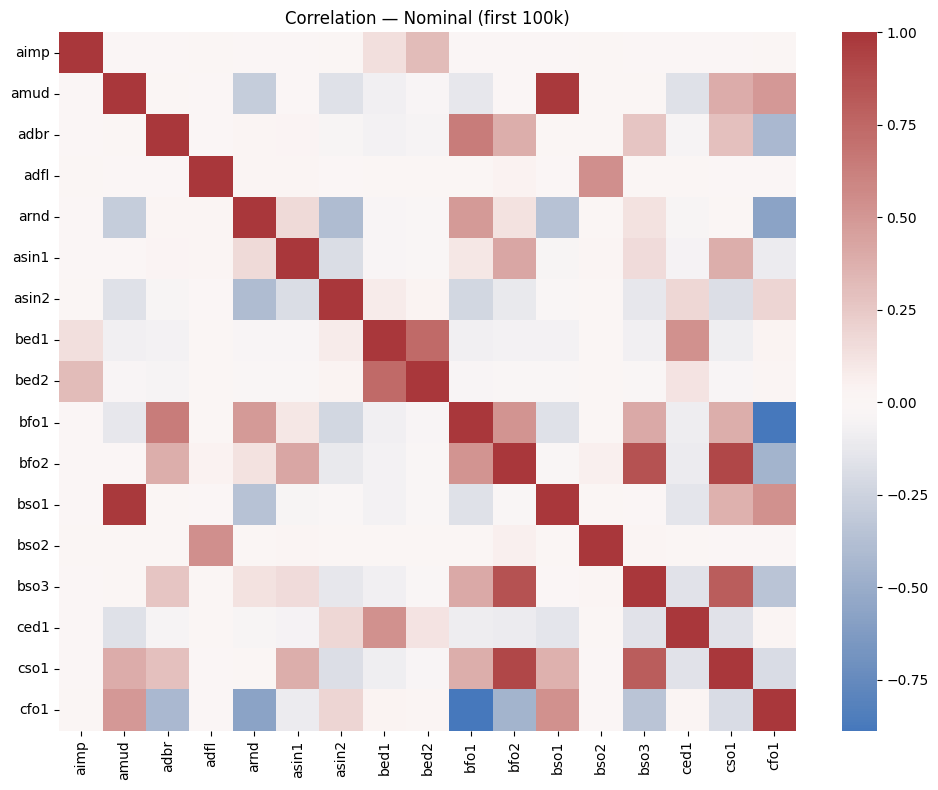

[EDA] Post-nominal (next 100k): shape=(100000, 17)
Missing values:
 aimp     0
amud     0
arnd     0
asin1    0
asin2    0
adbr     0
adfl     0
bed1     0
bed2     0
bfo1     0
bfo2     0
bso1     0
bso2     0
bso3     0
ced1     0
cfo1     0
cso1     0
dtype: int64
Summary statistics:
                 aimp           amud           arnd          asin1  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.010040       1.213950      17.499725       0.704026   
std         0.099696       7.090498       7.137831       0.308673   
min         0.000000     -18.000000      10.000000      -0.008831   
25%         0.000000      -2.000000      11.925159       0.471652   
50%         0.000000       2.000000      15.182608       0.836661   
75%         0.000000       5.000000      20.985901       0.968911   
max         1.000000      17.000000      48.991336       1.000000   

               asin2           adbr           adfl           bed1  \
count  100000.000000

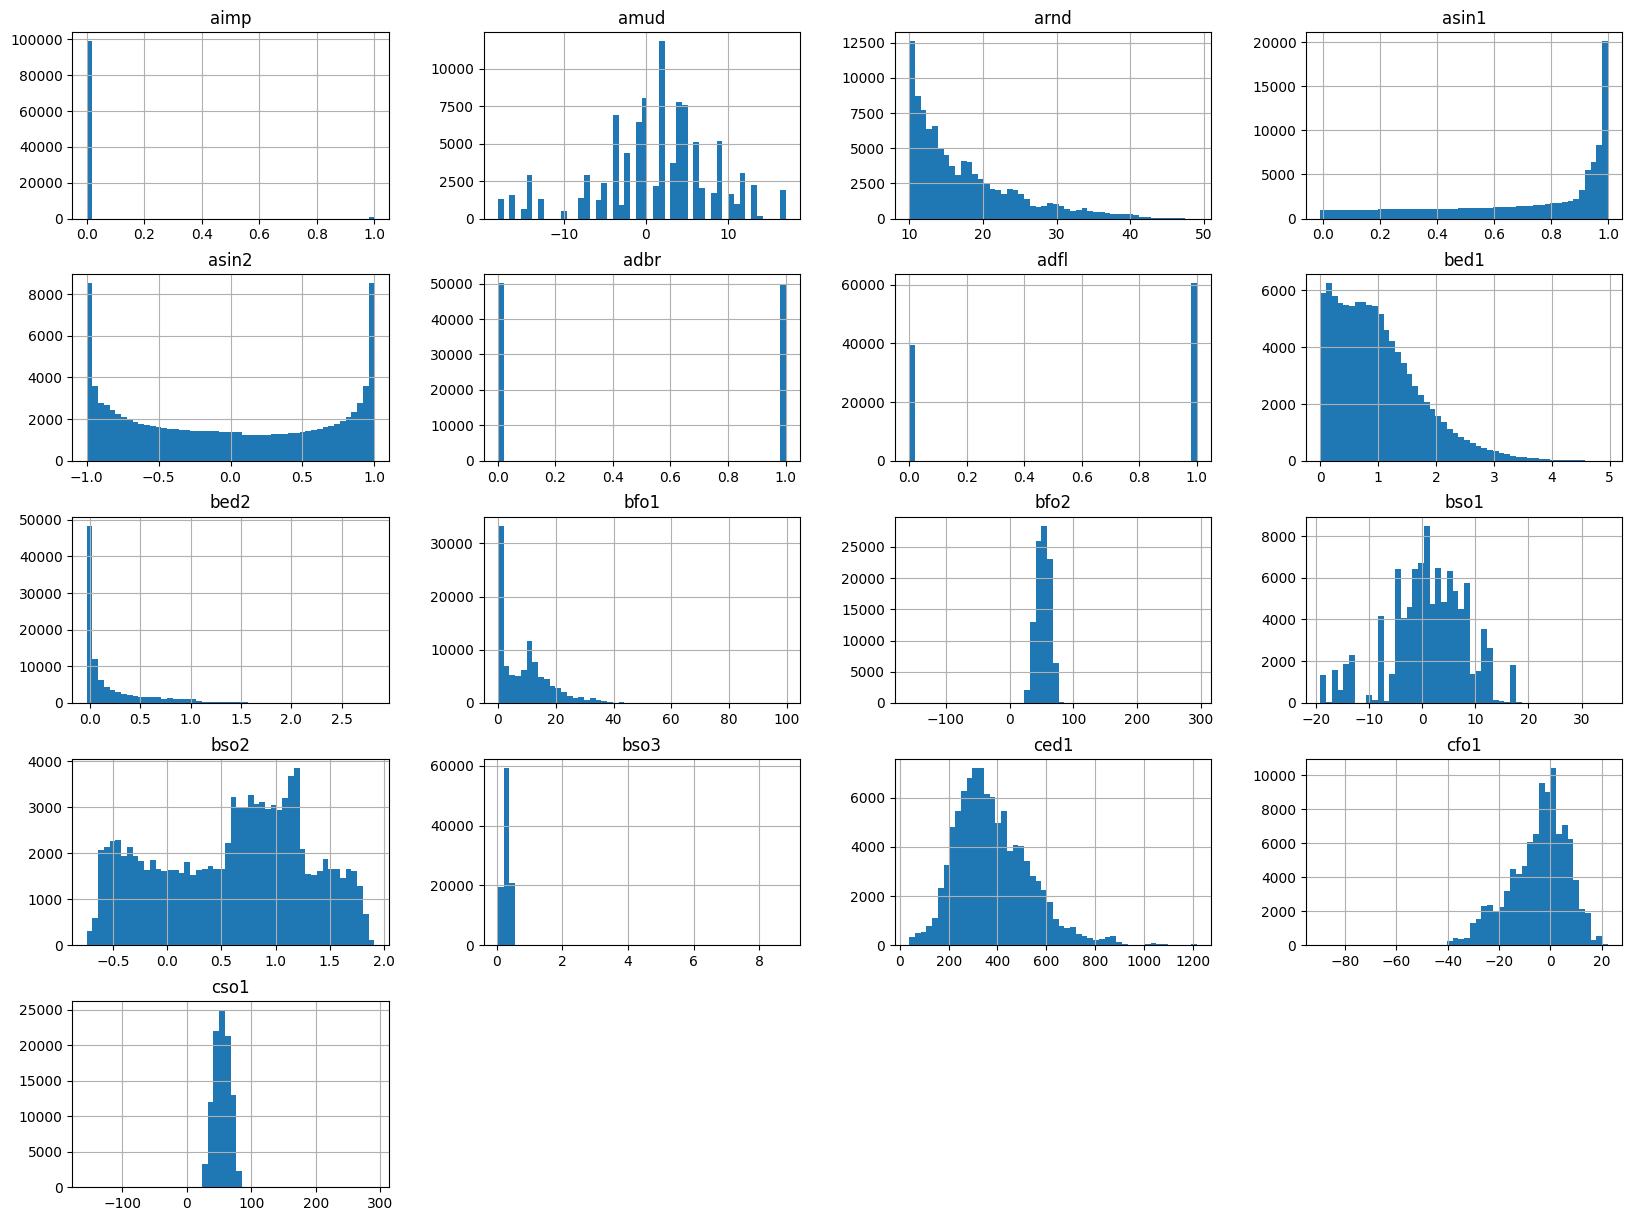

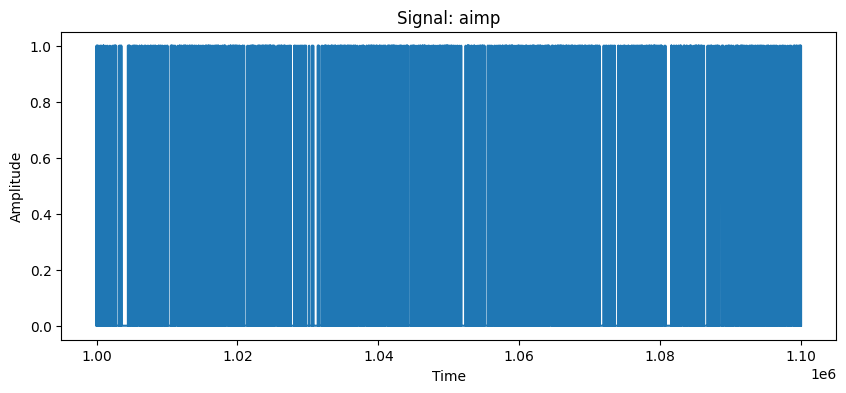

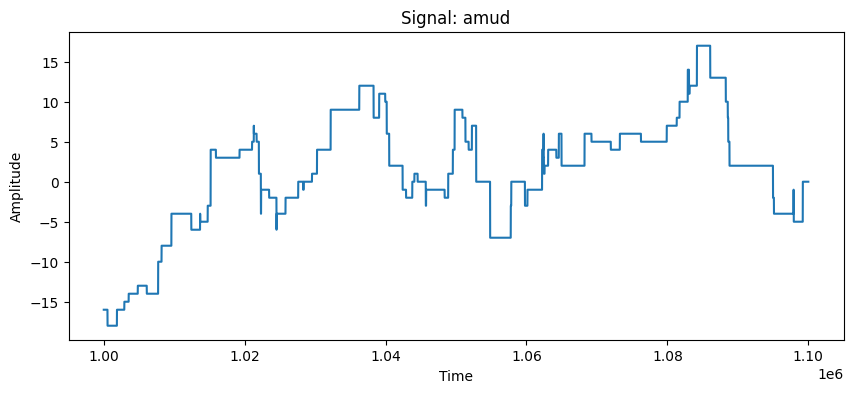

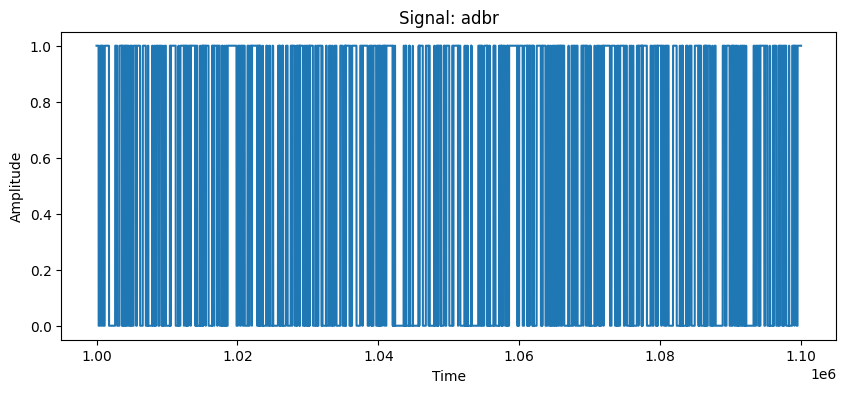

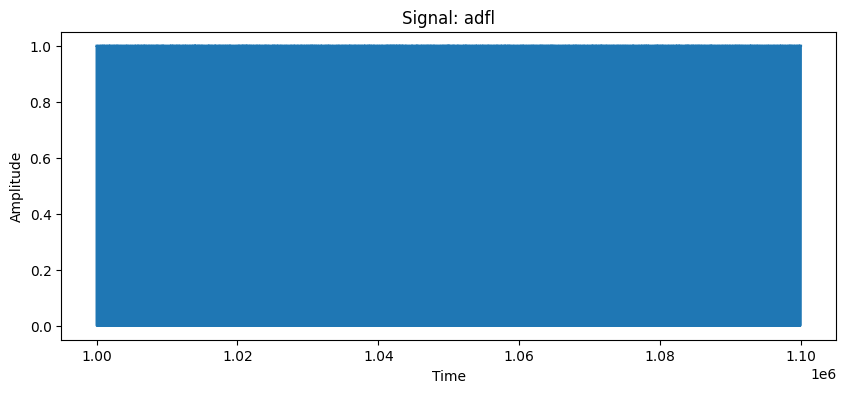

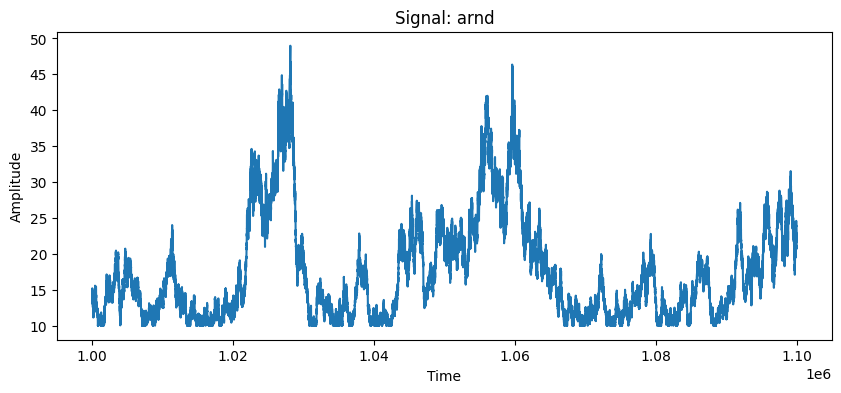

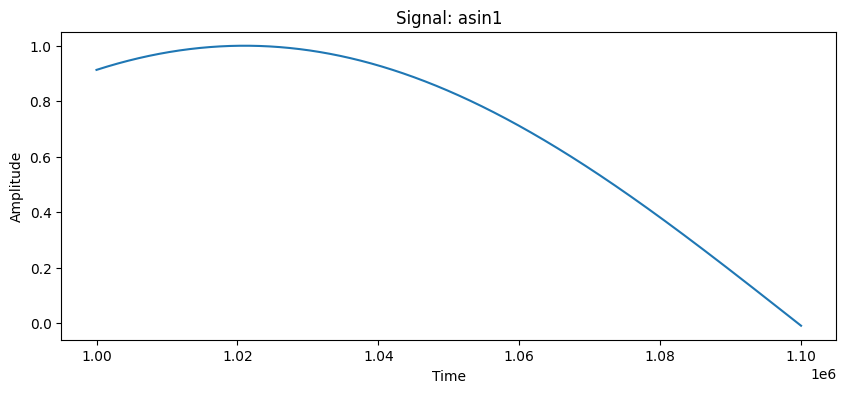

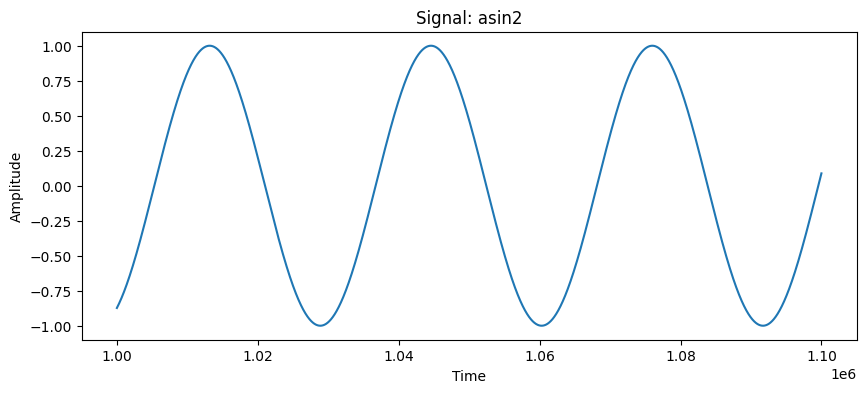

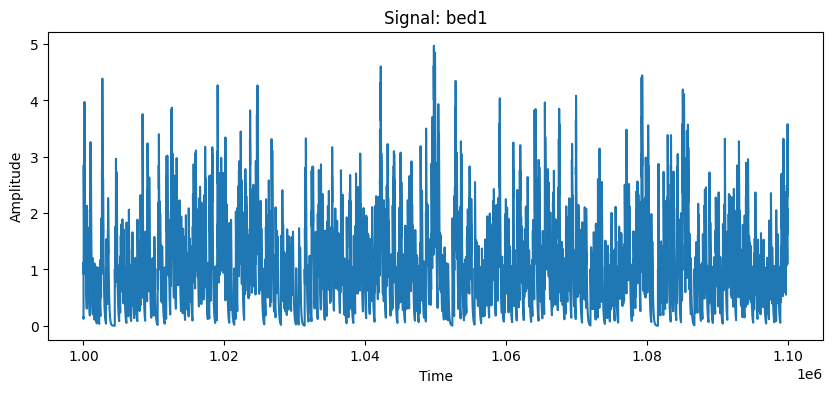

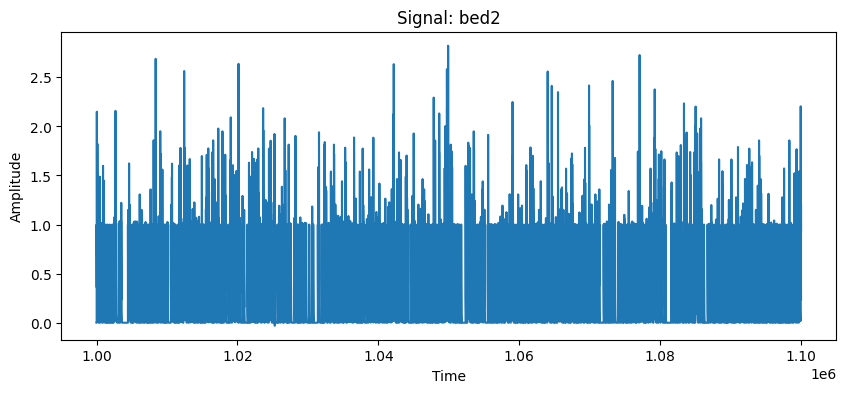

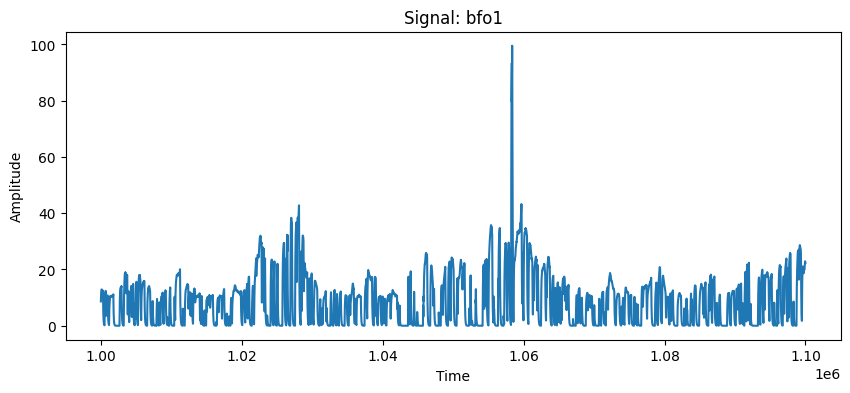

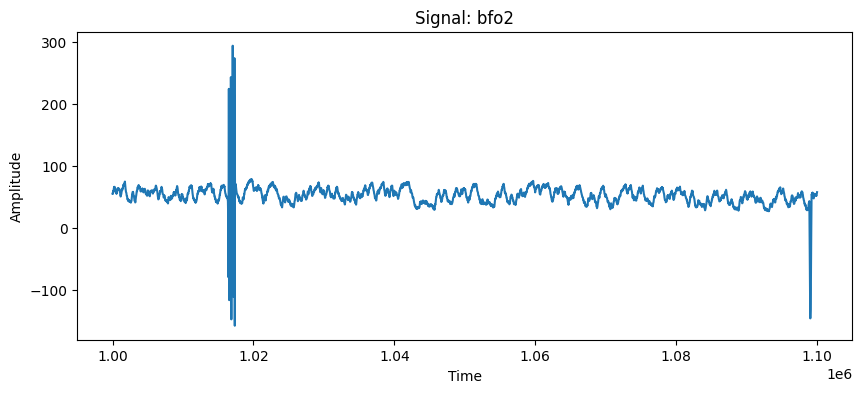

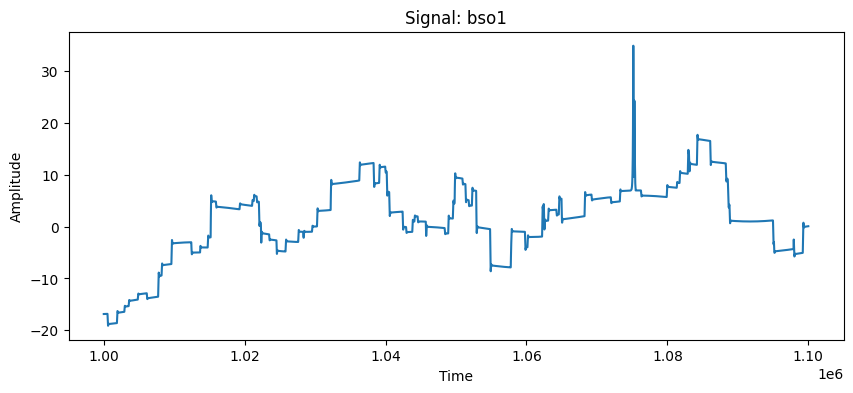

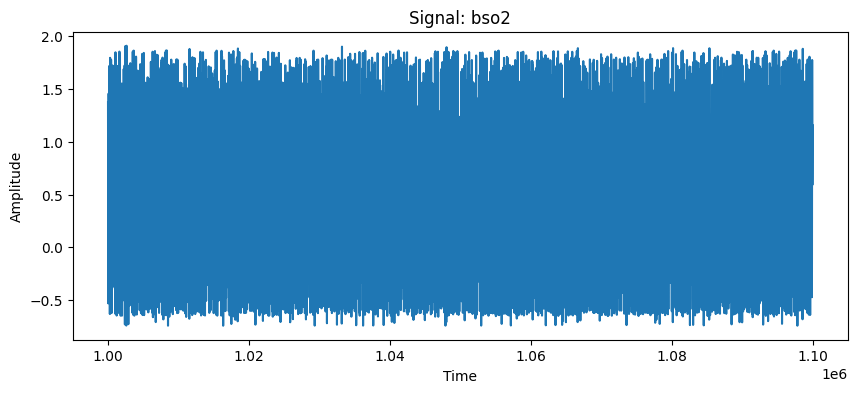

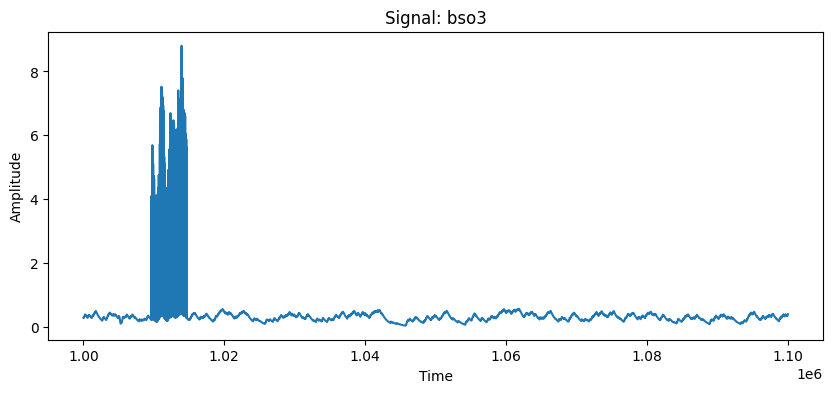

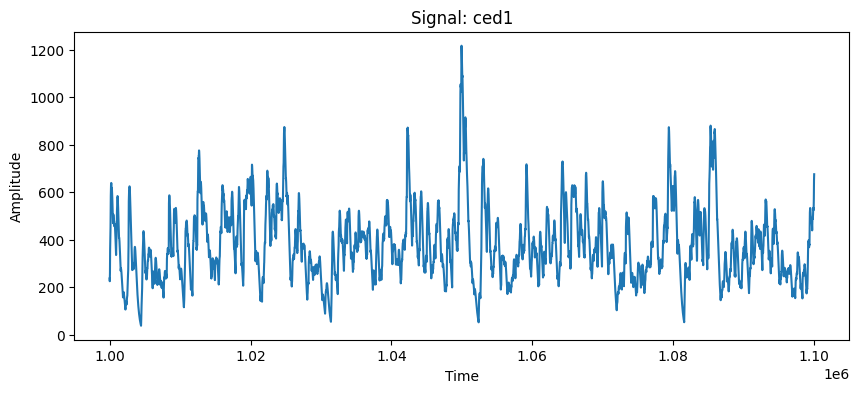

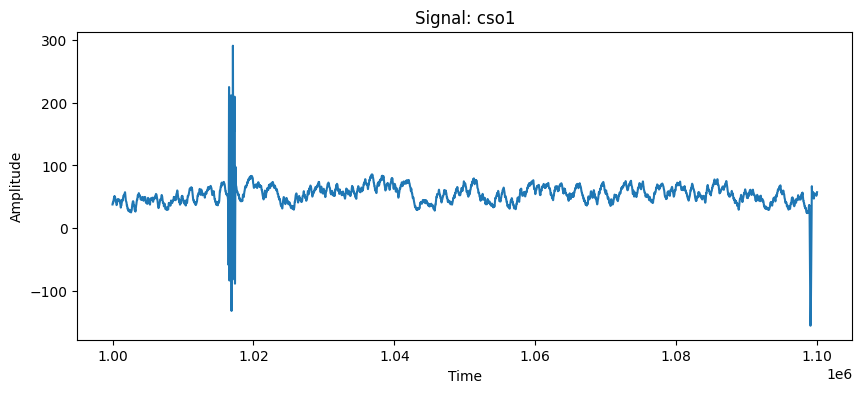

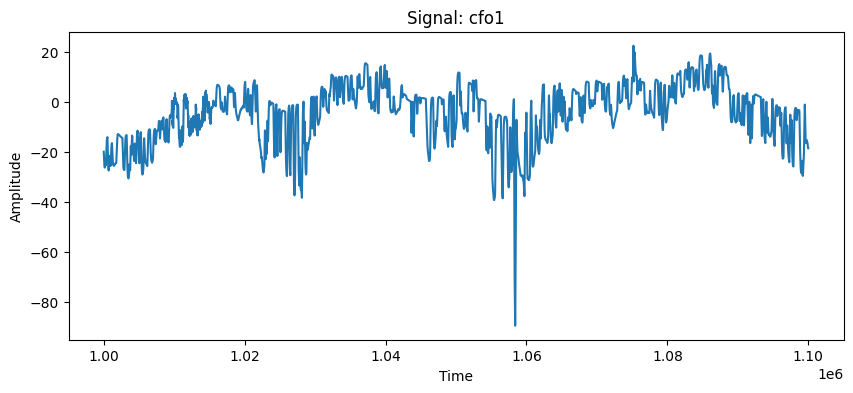

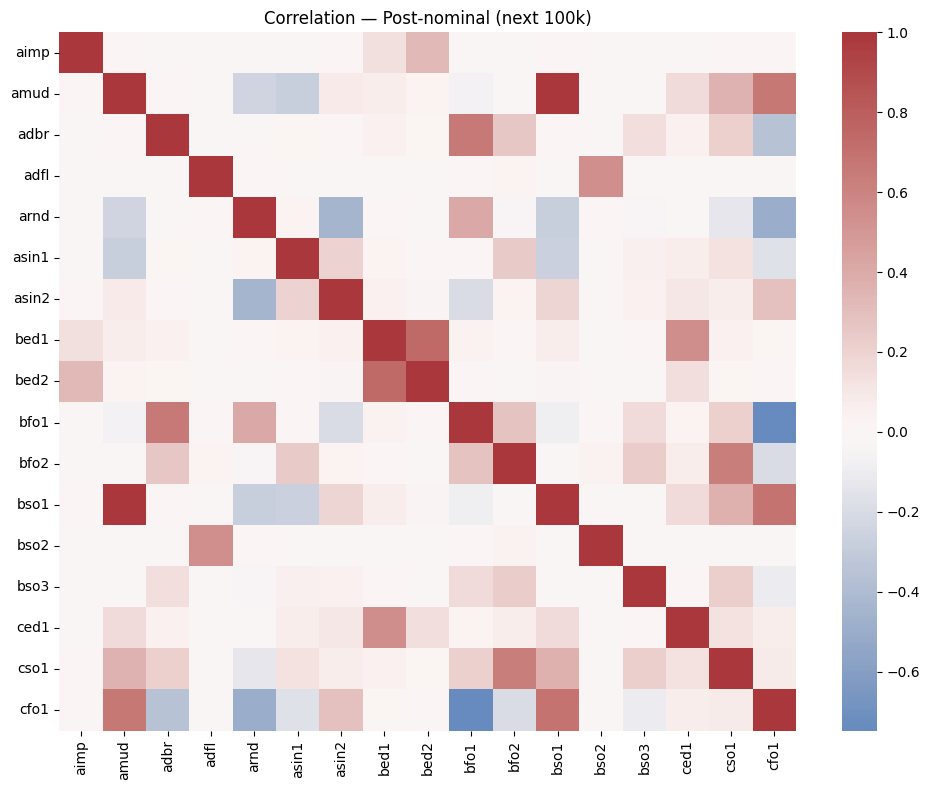

[sync] Spectral init periods: [4347.826086956522]

Start of sine representation pre-train epoch 0
sine_loss: 15.679165
Start of sine representation pre-train epoch 1
sine_loss: 15.588576
Start of sine representation pre-train epoch 2
sine_loss: 15.508122
Start of sine representation pre-train epoch 3
sine_loss: 15.431628
Start of sine representation pre-train epoch 4
sine_loss: 15.356036
Start of sine representation pre-train epoch 5
sine_loss: 15.281389
Start of sine representation pre-train epoch 6
sine_loss: 15.207319
Start of sine representation pre-train epoch 7
sine_loss: 15.134475
Start of sine representation pre-train epoch 8
sine_loss: 15.062017
Start of sine representation pre-train epoch 9
sine_loss: 14.990513
Start of epoch 0
sine_loss: 14.917345 upper_bound_loss: 17.03492 lower_bound_loss: 1.5845159
Start of epoch 1
sine_loss: 14.847251 upper_bound_loss: 1.4044678 lower_bound_loss: 1.3368376
Start of epoch 0
sine_loss: 18.778458 upper_bound_loss: 0.7800175 lower_bound_loss

In [ ]:
# ==================== Consolidated, CATS-aware main() with streaming + EDA ====================
import numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns

TIME_COL = None  # e.g., "timestamp", "time", "datetime"
TIME_COL_CANDIDATES = ("timestamp","time","datetime","date","ts")

# --- CATS schema (17 channels) ---
CMD_COLS = ['AIMP','AMUD','ADBR','ADFL']  # 4 deliberate actuations / commands
ENV_COLS = ['ARND','ASIN1','ASIN2']       # 3 environmental stimuli
TEL_COLS = ['BED1','BED2','BFO1','BFO2','BSO1','BSO2','BSO3','CED1','CSO1','CFO1']  # 10 telemetry
SIGNAL_COLUMNS = CMD_COLS + ENV_COLS + TEL_COLS

# --- Paths & streaming params ---
FILE_PATH = r"D:/Projects/Anomaly Detection and Predictive Modelling for Multivariate Time Series Data/data.csv"
METADATA_PATH = r"D:/Projects/Anomaly Detection and Predictive Modelling for Multivariate Time Series Data/metadata.csv"
CHUNK_SIZE = 200_000             # stream size (adjust if memory allows)
TRAIN_ROWS = 1_000_000           # per CATS: first 1M are nominal
EPOCHS_PER_CHUNK = 2             # light passes per chunk (keeps wall-time reasonable)
BATCH_SIZE = 360                 #batch size
SEED = 42

# ---------- small helpers (local to this cell) ----------
def resolve_columns(actual_cols, expected_cols):
    """Case-insensitive resolution from expected -> actual names in the CSV."""
    lowmap = {c.lower(): c for c in actual_cols}
    resolved = []
    for want in expected_cols:
        key = want.lower()
        if key not in lowmap:
            raise ValueError(f"Column not found (case-insensitive): {want}")
        resolved.append(lowmap[key])
    return resolved

def read_chunks(filepath, usecols, chunksize, start_row=0, max_rows=None):
    """Stream `usecols` from CSV with optional start/stop window."""
    read = 0
    for df in pd.read_csv(filepath, usecols=usecols, chunksize=chunksize):
        if start_row > 0:
            if start_row >= len(df):
                start_row -= len(df)
                continue
            df = df.iloc[start_row:]
            start_row = 0
        if max_rows is not None:
            if read >= max_rows:
                break
            take = max_rows - read
            if len(df) > take:
                df = df.iloc[:take]
        read += len(df)
        if len(df):
            yield df 

def _spectral_freq_init_from_batch(x_batch: np.ndarray,
                                   min_periods: int,
                                   max_freqs: int,
                                   min_dist: int,
                                   force_sync: bool):
    """
    Compute dominant angular frequencies directly from data (no freqcoder).
    Uses mean across features -> normalize -> Periodogram -> peak picking.
    Returns: list of angular frequencies, or None.
    """
    # mean across features then scale to [-1, 1]
    z = x_batch.mean(axis=1).astype(np.float32)
    zmin, zmax = float(z.min()), float(z.max())
    if zmax > zmin:
        z = ((z - zmin) / (zmax - zmin)) * 2.0 - 1.0
    else:
        return None

    p = Periodogram(z, sampling=1.0)
    p()
    from scipy.signal import find_peaks
    peak_idxs, _ = find_peaks(p.psd, distance=min_dist, height=(0, np.inf))
    if len(peak_idxs) == 0:
        return None

    order = np.argsort(p.psd[peak_idxs])[::-1]
    peak_idxs = peak_idxs[order]
    ok = [idx for idx in peak_idxs if idx >= min_periods]
    if len(ok) == 0:
        return None if not force_sync else []

    ok = ok[:max_freqs]
    freqs = [p.frequencies()[idx] for idx in ok]     # Hz
    ang = [2.0 * np.pi * f for f in freqs]          # angular
    return ang

def quick_eda_sample(filepath, cols, start_row, max_rows, title=""):
    """Run light EDA/plots on a small slice."""
    sample = next(read_chunks(filepath, cols, chunksize=max_rows, start_row=start_row, max_rows=max_rows))
    print(f"[EDA] {title}: shape={sample.shape}")
    # Use existing helpers if present
    try:
        perform_eda(sample)
        visualize_signals(sample, cols)
    except NameError:
        print(sample.describe().T.head())
        sample[cols[:6]].plot(figsize=(12,5), linewidth=1, title=f"Signals preview — {title}")
        plt.tight_layout(); plt.show()
    # Correlation heatmap on a subset
    sub = sample[cols]
    if len(sub) > 50_000: sub = sub.sample(50_000, random_state=SEED)
    plt.figure(figsize=(10,8)); sns.heatmap(sub.corr(), cmap="vlag", center=0)
    plt.title(f"Correlation — {title}"); plt.tight_layout(); plt.show()

def fit_on_nominal_region(model, filepath, cols, chunksize, train_rows, batch_size, epochs_per_chunk):
    """Fit on the first 1M nominal rows (streamed, no shuffle)."""
    t_offset = 0
    total = 0
    for df in read_chunks(filepath, cols, chunksize, start_row=0, max_rows=train_rows):
        x = df.values.astype(np.float32)            # (n, F)
        t = np.arange(t_offset, t_offset + len(df), dtype=np.float32).reshape(-1, 1)   # 1 Hz
        t_mat = np.repeat(t, x.shape[1], axis=1).astype(np.float32)                   # (n, F)
        model.fit(x, t_mat, epochs=epochs_per_chunk, batch_size=batch_size, shuffle=False)
        t_offset += len(df); total += len(df)
    return total

def predict_and_accumulate_metrics(model, filepath, cols, chunksize, start_row, batch_size):
    """Stream prediction; accumulate coverage & mean violation (no huge arrays kept)."""
    t_offset = start_row
    total_points = 0
    total_inside = 0
    violation_sum = 0.0

    for df in read_chunks(filepath, cols, chunksize, start_row=start_row, max_rows=None):
        x = df.values.astype(np.float32)  # (n, F)
        t = np.arange(t_offset, t_offset + len(df), dtype=np.float32).reshape(-1, 1)
        t_mat = np.repeat(t, x.shape[1], axis=1).astype(np.float32)

        # predict in sub-batches
        ds = tf.data.Dataset.from_tensor_slices((x, t_mat)).batch(512)
        o_hi_list, o_lo_list = [], []
        for xb, tb in ds:
            out = model.predict(xb.numpy(), tb.numpy(), batch_size=512)
            if model.synchronize:
                _, _, hi_i, lo_i = out    # 4-tuple when synchronize=True
            else:
                hi_i, lo_i = out          # 2-tuple when synchronize=False

            # Reduce across estimators if present: (batch, n_estimators, F) -> (batch, F)
            if hi_i.ndim == 3:
                hi_i = np.median(hi_i, axis=1)
                lo_i = np.median(lo_i, axis=1)

            o_hi_list.append(hi_i)
            o_lo_list.append(lo_i)

        o_hi = np.concatenate(o_hi_list, axis=0)  # (n, F)
        o_lo = np.concatenate(o_lo_list, axis=0)  # (n, F)  

        pos_hi = np.maximum(0.0, x - o_hi)
        pos_lo = np.maximum(0.0, o_lo - x)
        excess = pos_hi + pos_lo                          # (n, F)

        inside = (excess == 0.0).sum()
        viol = excess[excess > 0.0].sum() if np.any(excess > 0.0) else 0.0

        total_inside  += int(inside)
        total_points  += excess.size
        violation_sum += float(viol)
        t_offset += len(df)

    coverage = total_inside / total_points if total_points > 0 else 0.0
    denom = (total_points - total_inside)
    mean_violation = violation_sum / denom if denom > 0 else 0.0
    return coverage, mean_violation

def coverage_on_range(model, filepath, cols, start_row, rows, chunksize=200_000, batch_size=512):
    """Compute coverage & mean violation on [start_row, start_row+rows) streaming through read_chunks()."""
    import numpy as np, tensorflow as tf

    t_offset = start_row
    total_points = 0
    total_inside = 0
    violation_sum = 0.0

    for df in read_chunks(filepath, cols, chunksize, start_row=start_row, max_rows=rows):
        x = df.values.astype(np.float32)  # (n, F)

        # build the time matrix aligned to global index
        t = np.arange(t_offset, t_offset + len(df), dtype=np.float32).reshape(-1, 1)
        t_mat = np.repeat(t, x.shape[1], axis=1).astype(np.float32)

        # predict in sub-batches
        ds = tf.data.Dataset.from_tensor_slices((x, t_mat)).batch(batch_size)
        o_hi_parts, o_lo_parts = [], []
        for xb, tb in ds:
            out = model.predict(xb.numpy(), tb.numpy(), batch_size=batch_size)
            if model.synchronize:
                _, _, hi_i, lo_i = out   # 4-tuple when synchronize=True
            else:
                hi_i, lo_i = out         # 2-tuple otherwise
            if hi_i.ndim == 3:           # (B, n_estimators, F) -> (B, F)
                hi_i = np.median(hi_i, axis=1)
                lo_i = np.median(lo_i, axis=1)
            o_hi_parts.append(hi_i); o_lo_parts.append(lo_i)

        o_hi = np.concatenate(o_hi_parts, axis=0)
        o_lo = np.concatenate(o_lo_parts, axis=0)

        # violations for this chunk
        excess = np.maximum(0.0, x - o_hi) + np.maximum(0.0, o_lo - x)  # (n, F)
        inside = (excess == 0.0).sum()
        viol = excess[excess > 0.0].sum() if np.any(excess > 0.0) else 0.0

        total_inside += int(inside)
        total_points += excess.size
        violation_sum += float(viol)
        t_offset += len(df)

    coverage = total_inside / total_points if total_points else 0.0
    denom = (total_points - total_inside)
    mean_violation = violation_sum / denom if denom > 0 else 0.0
    return coverage, mean_violation


def stream_violation_scores(model, filepath, cols, start_row, chunksize=200_000, batch_size=512, agg="linf"):
    t_offset = start_row
    global_idx = start_row

    for df in read_chunks(filepath, cols, chunksize, start_row=start_row, max_rows=None):
        x = df.values.astype(np.float32)
        t = np.arange(t_offset, t_offset + len(df), dtype=np.float32).reshape(-1, 1)
        t_mat = np.repeat(t, x.shape[1], axis=1).astype(np.float32)

        ds = tf.data.Dataset.from_tensor_slices((x, t_mat)).batch(batch_size)
        scores_parts = []
        for xb, tb in ds:
            out = model.predict(xb.numpy(), tb.numpy(), batch_size=batch_size)
            if model.synchronize:
                _, _, hi_i, lo_i = out
            else:
                hi_i, lo_i = out
            if hi_i.ndim == 3:
                hi_i = np.median(hi_i, axis=1); lo_i = np.median(lo_i, axis=1)

            excess = np.maximum(0.0, xb.numpy() - hi_i) + np.maximum(0.0, lo_i - xb.numpy())

            if agg == "linf":
                sc = excess.max(axis=1)
            elif agg == "l1":
                sc = excess.sum(axis=1)
            elif agg == "l2":
                sc = np.sqrt((excess**2).sum(axis=1))
            else:
                sc = excess.max(axis=1)

            scores_parts.append(sc.astype(np.float32))

        scores = np.concatenate(scores_parts, axis=0)
        yield (global_idx, global_idx + len(df), scores)

        t_offset += len(df); global_idx += len(df)


def choose_threshold_by_contamination(scores_iter, expected_contam=0.038, sample_size=500_000, seed=42):
    """
    Pick a threshold tau so that about `expected_contam` fraction are positive.
    Uses a memory-safe reservoir sample (approximate quantile).
    """
    import numpy as np, random
    rng = random.Random(seed)

    # reservoir
    R = None
    n_seen = 0
    for _, _, s in scores_iter:
        s = np.asarray(s)
        if R is None:
            R = s[:min(len(s), sample_size)].copy()
            n_seen = len(s)
        else:
            for v in s:
                n_seen += 1
                if len(R) < sample_size:
                    R = np.append(R, v)
                else:
                    j = rng.randrange(n_seen)
                    if j < sample_size:
                        R[j] = v

    if R is None or len(R) == 0:
        return 0.0

    q = np.quantile(R, 1.0 - expected_contam)  # approximate global (1-contam) quantile
    return float(q)

def choose_tau_on_nominal_window(model, filepath, cols, start_row, rows,
                                 chunksize=200_000, batch_size=512, agg="linf",
                                 q=0.995):
    """
    Pick tau as the q-quantile of scores computed on a *nominal-only* window.
    """
    import numpy as np
    from random import Random

    rng = Random(42)
    sample_size = 500_000
    R = None
    n_seen = 0

    for lo, hi, scores in stream_violation_scores(
        model, filepath, cols,
        start_row=start_row, chunksize=chunksize, batch_size=batch_size, agg=agg
    ):
        # only use [start_row, start_row+rows)
        if hi <= start_row + rows:
            s = np.asarray(scores)
            if R is None:
                R = s[:min(len(s), sample_size)].copy()
                n_seen = len(s)
            else:
                for v in s:
                    n_seen += 1
                    if len(R) < sample_size:
                        R = np.append(R, v)
                    else:
                        j = rng.randrange(n_seen)
                        if j < sample_size:
                            R[j] = v
        else:
            break

    if R is None or len(R) == 0:
        return 0.0

    return float(np.quantile(R, q))

def choose_tau_by_max_f1_on_dev(model, filepath, cols, segments,
                                dev_start, dev_rows,
                                chunksize=200_000, batch_size=512, agg="linf",
                                sample_size=600_000, seed=42):
    """
    Stream scores & labels on a labeled dev window and pick tau that maximizes F1.
    Uses a reservoir sample to keep memory bounded.
    """
    import numpy as np, random
    rng = random.Random(seed)

    # 1) Reservoir sample of (score, label) pairs from the dev window
    S = None    # scores
    L = None    # labels (bool)
    n_seen = 0

    # Convert segment list into a simple iterator
    segs = segments
    p = 0
    nsegs = len(segs)

    dev_end = dev_start + dev_rows
    for lo, hi, scores in stream_violation_scores(model, filepath, cols,
                                                  start_row=dev_start, chunksize=chunksize,
                                                  batch_size=batch_size, agg=agg):
        if lo >= dev_end:
            break
        hi = min(hi, dev_end)

        idx = np.arange(lo, hi, dtype=np.int64)
        s   = np.asarray(scores, dtype=np.float32)

        # Build truth mask for [lo, hi)
        truth = np.zeros(len(idx), dtype=bool)
        # Advance p to first seg that might overlap
        while p < nsegs and segs[p][1] <= lo:
            p += 1
        q = p
        while q < nsegs and segs[q][0] < hi:
            a = max(segs[q][0], lo) - lo
            b = min(segs[q][1], hi) - lo
            if a < b:
                truth[a:b] = True
            q += 1

        # Reservoir sample
        if S is None:
            take = min(len(s), sample_size)
            S = s[:take].copy()
            L = truth[:take].copy()
            n_seen = len(s)
        else:
            for si, li in zip(s, truth):
                n_seen += 1
                if len(S) < sample_size:
                    S = np.append(S, si)
                    L = np.append(L, li)
                else:
                    j = rng.randrange(n_seen)
                    if j < sample_size:
                        S[j] = si
                        L[j] = li

    if S is None or len(S) == 0:
        return 0.0

    # 2) Scan a grid of percentiles to maximize F1
    percentiles = np.linspace(80, 99.9, 60)  # coarse→fine
    best_tau, best_f1 = None, -1.0
    for pctl in percentiles:
        tau = float(np.percentile(S, pctl))
        pred = (S >= tau)
        TP = int(np.sum(pred & L))
        FP = int(np.sum(pred & ~L))
        FN = int(np.sum((~pred) & L))
        prec = TP / (TP + FP) if (TP+FP) else 0.0
        rec  = TP / (TP + FN) if (TP+FN) else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
        if f1 > best_f1:
            best_f1, best_tau = f1, tau
    print(f"[dev-thresh] best F1={best_f1:.4f} at tau={best_tau:.6f}")
    return best_tau


def _segments_from_times_csv(file_path: str, time_col: str, starts, ends) -> list[tuple[int,int]]:
    """
    Convert timestamp ranges (starts, ends) into [start_idx, end_idx) row index segments
    by scanning data.csv in chunks (time column only).
    Assumes the CSV is sorted by time_col (usual for CATS).
    """
    starts = pd.to_datetime(starts, errors="coerce").to_numpy()
    ends   = pd.to_datetime(ends,   errors="coerce").to_numpy()
    if np.any(pd.isna(starts)) or np.any(pd.isna(ends)):
        raise ValueError("Some start_time/end_time values could not be parsed as datetimes.")

    # Sort segments by start_time to scan once, left-to-right
    order = np.argsort(starts)
    starts, ends = starts[order], ends[order]

    n = len(starts)
    start_idx = np.full(n, -1, dtype=np.int64)
    end_idx   = np.full(n, -1, dtype=np.int64)

    # Stream the CSV: only the time column to keep it light
    global_offset = 0
    for chunk in pd.read_csv(file_path, usecols=[time_col], chunksize=200_000):
        ts = pd.to_datetime(chunk[time_col], errors="coerce").to_numpy()
        # skip malformed rows silently
        valid = ~pd.isna(ts)
        ts = ts[valid]
        if ts.size == 0:
            global_offset += len(chunk)
            continue

        t0, t1 = ts[0], ts[-1]

        # For any segment whose boundary falls into [t0, t1], resolve indices by searchsorted
        # NOTE: searchsorted is on the local ts; add global_offset to get global indices.
        # Starts
        mask_s = (start_idx == -1) & (starts >= t0) & (starts <= t1)
        if np.any(mask_s):
            s_local = np.searchsorted(ts, starts[mask_s], side="left")
            start_idx[mask_s] = global_offset + np.searchsorted(valid.nonzero()[0], s_local, side="left")  # align to original rows

        # Ends
        mask_e = (end_idx == -1) & (ends >= t0) & (ends <= t1)
        if np.any(mask_e):
            e_local = np.searchsorted(ts, ends[mask_e], side="left")
            end_idx[mask_e] = global_offset + np.searchsorted(valid.nonzero()[0], e_local, side="left")

        global_offset += len(chunk)

        # Early exit if all resolved
        if np.all(start_idx != -1) and np.all(end_idx != -1):
            break

    # Any segments that are still unresolved (e.g., start/end outside data range)
    unresolved = np.where((start_idx == -1) | (end_idx == -1))[0]
    if unresolved.size:
        raise ValueError(
            f"Could not map {unresolved.size} segment(s) from times to indices. "
            f"Check that '{time_col}' exists in data.csv and times overlap the dataset."
        )

    # Pack, restore original order
    segs = [(int(start_idx[i]), int(end_idx[i])) for i in range(n)]
    # restore original ordering of metadata rows
    inv = np.zeros_like(order); inv[order] = np.arange(n)
    segs = [segs[i] for i in inv]

    # ensure end > start
    segs = [(s,e) for (s,e) in segs if e > s]
    segs.sort()
    return segs


def load_anomaly_segments(metadata_path: str,
                          train_rows: int = 1_000_000,
                          file_path: str | None = None,
                          time_col: str | None = None):
    """
    Supports two metadata formats:
      1) index-based:  'start_idx' / 'end_idx' (or similar)
      2) time-based:   'start_time' / 'end_time'  (requires file_path & time_col)
    """
    import os
    ext = os.path.splitext(metadata_path.lower())[1]
    dfm = pd.read_parquet(metadata_path) if ext in (".parquet", ".pq") else pd.read_csv(metadata_path)
    cols = {c.lower(): c for c in dfm.columns}

    # Case A: index-based (fast path)
    start_key = next((k for k in ("start_idx","start_index","start","t_start","begin") if k in cols), None)
    end_key   = next((k for k in ("end_idx","end_index","end","t_end","finish")     if k in cols), None)
    if start_key is not None and end_key is not None:
        s = dfm[cols[start_key]].astype(int).to_numpy()
        e = dfm[cols[end_key]].astype(int).to_numpy()
        if np.max(s) < train_rows:
            s = s + train_rows; e = e + train_rows
        segs = [(int(si), int(ei)) for si, ei in zip(s, e) if ei > si]
        segs.sort()
        return segs

    # Case B: time-based (metadata.csv)
    st_key = next((k for k in ("start_time","start","t_start") if k in cols), None)
    et_key = next((k for k in ("end_time","end","t_end")       if k in cols), None)
    if st_key and et_key:
        if file_path is None:
            raise ValueError("Need file_path (data.csv) to map times to indices.")
        # determine time column
        if time_col is None:
            head_cols = pd.read_csv(file_path, nrows=5).columns.tolist()
            lower = {c.lower(): c for c in head_cols}
            cand = next((lower[c] for c in TIME_COL_CANDIDATES if c in lower), None)
            if cand is None:
                raise ValueError(
                    "Could not auto-detect a time column in data.csv. "
                    "Set TIME_COL to your timestamp column name."
                )
            time_col = cand

        starts = dfm[cols[st_key]].to_numpy()
        ends   = dfm[cols[et_key]].to_numpy()
        return _segments_from_times_csv(file_path, time_col, starts, ends)

    raise ValueError(
        "Could not find start/end in metadata.csv. "
        "Supported: [start_idx/end_idx ...] or [start_time/end_time ...]."
    )

def evaluate_pointwise_from_predictions(pred_csv_path, segments, chunksize=1_000_000):
    """
    Streaming point-wise precision/recall/F1 using the predictions CSV we wrote:
    columns: idx, score, is_anom
    """
    import numpy as np, pandas as pd

    # compact list of segments; iterate once
    segs = segments
    seg_ptr = 0
    n_segs = len(segs)

    TP = FP = FN = 0

    for df in pd.read_csv(pred_csv_path, chunksize=chunksize):
        idx = df["idx"].to_numpy(dtype=np.int64)
        pred = (df["is_anom"].to_numpy(dtype=np.int8) > 0)
        if len(idx) == 0:
            continue

        lo, hi = int(idx[0]), int(idx[-1] + 1)
        truth = np.zeros(hi - lo, dtype=bool)

        # mark truth by intersecting segments that overlap [lo, hi)
        while seg_ptr > 0 and segs[seg_ptr-1][1] > lo:
            seg_ptr -= 1
        p = seg_ptr
        while p < n_segs and segs[p][0] < hi:
            s, e = segs[p]
            a, b = max(s, lo), min(e, hi)
            if a < b:
                truth[a - lo : b - lo] = True
            p += 1

        # align pred to [lo,hi)
        # our idx is contiguous from lo..hi-1 in the CSV chunks
        TP += int(np.sum(pred & truth))
        FP += int(np.sum(pred & ~truth))
        FN += int(np.sum((~pred) & truth))

        # advance pointer to first segment with end > hi
        while seg_ptr < n_segs and segs[seg_ptr][1] <= hi:
            seg_ptr += 1

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    return precision, recall, f1


def main():
    tf.keras.backend.clear_session()

    # --- discover actual column names & resolve to schema (case-insensitive) ---
    import os
    head_cols = pd.read_csv(FILE_PATH, nrows=5).columns.tolist()

    resolved_cols = resolve_columns(head_cols, SIGNAL_COLUMNS)
    print("Resolved columns:", resolved_cols)

    # --- quick EDA on small slices (nominal + post-nominal) ---
    quick_eda_sample(FILE_PATH, resolved_cols, start_row=0,          max_rows=100_000,   title="Nominal (first 100k)")
    quick_eda_sample(FILE_PATH, resolved_cols, start_row=TRAIN_ROWS, max_rows=100_000,   title="Post-nominal (next 100k)")

    # --- init model (keep your hyperparams) ---
    model = RANSynCoders(synchronize=True, latent_dim=2, delta=0.05)

    # --- train on 1M nominal (streamed) ---
    trained_rows = fit_on_nominal_region(
        model, FILE_PATH, resolved_cols, CHUNK_SIZE, TRAIN_ROWS, BATCH_SIZE, EPOCHS_PER_CHUNK
    )
    print(f"[train] Completed on nominal region: {trained_rows} rows")

    cov_nom, mv_nom = coverage_on_range(model, FILE_PATH, resolved_cols, start_row=800_000, rows=200_000)
    print(f"[calib] Nominal holdout coverage: {cov_nom:.4f} | mean violation: {mv_nom:.6f} (target ~0.90)")

    # --- predict on remaining ~4M (streamed, accumulate metrics) ---
    coverage, mean_violation = predict_and_accumulate_metrics(
        model, FILE_PATH, resolved_cols, CHUNK_SIZE, start_row=TRAIN_ROWS, batch_size=BATCH_SIZE
    )
    print(f"[eval] Coverage: {coverage:.4f} | Mean violation: {mean_violation:.6f}")

    # --- anomaly scoring & thresholded list (streaming, memory-safe) ---
    '''
    AGG = "l2"  # try 'l2' first; often better than 'linf' for broader shifts

    # 1) pick tau from the nominal holdout window [800k, 1M)
    tau = choose_tau_on_nominal_window(
        model, FILE_PATH, resolved_cols,
        start_row=800_000, rows=200_000,
        chunksize=CHUNK_SIZE, batch_size=512, agg=AGG, q=0.995
    )
    '''
    AGG = "linf"  # try linf for spikes
    segments = load_anomaly_segments(
        METADATA_PATH, train_rows=TRAIN_ROWS, file_path=FILE_PATH, time_col=TIME_COL
    )

    # use the first 1M after TRAIN_ROWS as a labeled dev window (adjust if you like)
    tau = choose_tau_by_max_f1_on_dev(
        model, FILE_PATH, resolved_cols, segments,
        dev_start=TRAIN_ROWS, dev_rows=1_000_000,
        chunksize=CHUNK_SIZE, batch_size=512, agg=AGG
    )

    print(f"[thresh] tau (nominal q=0.995, agg={AGG}): {tau:.6f}")


    # 2) second pass to write a CSV of (idx, score, is_anom) without holding all in RAM
    out_path = "cats_anomalies_stream.csv"
    first = True
    for lo, hi, scores in stream_violation_scores(
            model, FILE_PATH, resolved_cols, start_row=TRAIN_ROWS, chunksize=CHUNK_SIZE, batch_size=512, agg=AGG):
        idx = np.arange(lo, hi, dtype=np.int64)
        is_anom = (scores >= tau).astype(np.int8)
        df_out = pd.DataFrame({"idx": idx, "score": scores, "is_anom": is_anom})
        df_out.to_csv(out_path, index=False, mode="w" if first else "a", header=first)
        first = False

    print(f"[write] {out_path}")

    # 3) load ground-truth segments and print precision/recall/F1 (pointwise)
    segments = load_anomaly_segments(
        METADATA_PATH,
        train_rows=TRAIN_ROWS,
        file_path=FILE_PATH,     # <-- needed for time→index mapping
        time_col=TIME_COL        # <-- leave None to auto-detect from TIME_COL_CANDIDATES
    )

    prec, rec, f1 = evaluate_pointwise_from_predictions(out_path, segments)
    print(f"[pointwise] precision={prec:.4f} | recall={rec:.4f} | F1={f1:.4f}")


# run in notebook
main()
